## Prevalence of Household Food Insecurity Experience Scale (FIES);An Exploratory Data Analysis

This study aimed to determine the prevalence of FI, and its associations with individual-/household-level and contextual-level factors among urban adults
in Nigeria.

### Objectivess and Hypothesis
* How do the age, sex, and education of the household head influence food insecurity in Nigeria?
* What individual factors are most strongly associated with food insecurity in Nigeria?
* How do household and community characteristics influence food security?

### Data Collection
The data analyzed in this study was acquired from UNICEF through a formal request. As this study involved secondary analy-
sis of publicly available de-identified Nigeria 2021 MICS6 data.

**Relevant Variables:**

* **Individual Level:** Demographic data, health insurance status, education level, life satisfaction, mean age of women and men, household head age, sex and education, avg men and women life satisfaction, number of men and women who attended school
* **Microsystem**: Household wealth index, household size, household own dwelling, agricultural land, Number of adult men and women, Number of children, zone, livestock ownership and number, number of children

In [77]:
# Import the required libraries and packages
import os
import sys

if os.path.abspath("../../../") not in sys.path:
    sys.path.append(os.path.abspath("../../../"))

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd


from scipy.stats import chi2_contingency, ttest_ind, f_oneway
from sklearn.preprocessing import MultiLabelBinarizer

# import utility functions 
import utils.eda as eda_utils

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row', 500)


In [3]:
# Read the dataset into a DataFrame


In [4]:
data = pd.read_csv("../processed_data/fies_probability_value_plus_clean_data.csv")
data.shape

(33631, 38)

In [5]:

import re
fies_df = pd.read_csv("../processed_data/hh_fies_df.csv")

fies_cols = ["hh1", "hh2"]+ [col for col in fies_df.columns if re.search(r'^(fe)\d+$', col)]

fies_data = fies_df.loc[:, fies_cols]


# Dictionary mapping Food Insecurity Experience Scale (FIES) item codes to their descriptive names
fies_dict = {
    "fe1": "WORRIED",
    "fe2": "HEALTHY",
    "fe3": "FEWFOOD",
    "fe4": "SKIPPED",
    "fe5": "ATELESS",
    "fe6": "RANOUT",
    "fe7": "HUNGRY",
    "fe8": "WHLDAY",
}
fies_data = fies_data.rename(columns=fies_dict)

### Merge FIES Question data
df = pd.merge(data, fies_data, on=["hh1", "hh2"], how="left")

In [6]:
df.shape

(33631, 46)

In [7]:
df.head(2)

,hh1,hh2,area,zone,hh_members_num,num_of_women_15_49,num_of_men_15_49,num_under_5_child,num_5_17_child,hhsex,hhage,helevel,hh_own_dwelling,hh_agricultural_land,hh_ag_land_size,hh_own_animal,hh_mn_attended_sch_num,hh_mn_mean_age_yrs,hh_mn_attended_atleast_sec_sch,hh_mn_mean_life_satisfaction,hh_wm_attended_sch_num,hh_wm_mean_age_yrs,hh_wm_attended_atleast_sec_sch,hh_wm_mean_life_satisfaction,water_source,other_water_source,water_source_location,wi_quintile_mics,wscoremics,urban_wi_quintile_mics,hh_ls_num,fies_score,hhweightmics,psu,stratum,prob_mod_sev,prob_sev,rs_fies_score,WORRIED,HEALTHY,FEWFOOD,SKIPPED,ATELESS,RANOUT,HUNGRY,WHLDAY
0,1.0,1.0,URBAN,South East,4.0,3.0,0.0,0.0,1.0,Female,46.0,Primary,RENT,NO,0.0,NO,NaN,NaN,NaN,NaN,3.0,28.666667,2.0,3.333333,TUBE WELL / BOREHOLE,NaN,ELSEWHERE,Fourth,0.839976,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0
1,1.0,2.0,URBAN,South East,2.0,2.0,0.0,0.0,1.0,Female,45.0,Senior secondary,RENT,NO,0.0,NO,NaN,NaN,NaN,NaN,2.0,30.500000,2.0,5.500000,TUBE WELL / BOREHOLE,NaN,ELSEWHERE,Fourth,0.695187,Second,0,6,0.61955,1.0,1.0,0.971,0.043,6,1,1,1,1,1,1,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33631 entries, 0 to 33630
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hh1                             33631 non-null  float64
 1   hh2                             33631 non-null  float64
 2   area                            33631 non-null  object 
 3   zone                            33631 non-null  object 
 4   hh_members_num                  33631 non-null  float64
 5   num_of_women_15_49              33631 non-null  float64
 6   num_of_men_15_49                33631 non-null  float64
 7   num_under_5_child               33631 non-null  float64
 8   num_5_17_child                  33631 non-null  float64
 9   hhsex                           33631 non-null  object 
 10  hhage                           33631 non-null  float64
 11  helevel                         23235 non-null  object 
 12  hh_own_dwelling                 

In [9]:
df.shape

(33631, 46)

### Data Cleaning and Preparation
* Investigate and Handle missing values related to the predictive and response variables
* Handle 'Dont know' and 'refused'.
* Convert variable values to the correct data type.
* Filter by URBAN Dataset only
* Investigate and Handle cases of outliers and abnormal values.
* Clean up certain columns and their values.
* Normalize and scale the data where needed

#### Investigate and Handle missing values related to the predictive and response variables

In [10]:
df.isna().sum()

hh1                                   0
hh2                                   0
area                                  0
zone                                  0
hh_members_num                        0
num_of_women_15_49                    0
num_of_men_15_49                      0
num_under_5_child                     0
num_5_17_child                        0
hhsex                                 0
hhage                                 0
helevel                           10396
hh_own_dwelling                       0
hh_agricultural_land                  0
hh_ag_land_size                      45
hh_own_animal                         0
hh_mn_attended_sch_num            21595
hh_mn_mean_age_yrs                21595
hh_mn_attended_atleast_sec_sch    21595
hh_mn_mean_life_satisfaction      21598
hh_wm_attended_sch_num             7904
hh_wm_mean_age_yrs                 7904
hh_wm_attended_atleast_sec_sch     7904
hh_wm_mean_life_satisfaction       7944
water_source                          0


In [11]:
def count_special_values(df: pd.DataFrame)->pd.DataFrame:
    """
    Counts the occurrences of specific special values (DK, REFUSED, NO RESPONSE, Missing/DK) 
    and missing values (NaN) in each column.
    
    Parameters:
    df (pandas DataFrame): The input DataFrame
    
    Returns:
    pandas DataFrame: A DataFrame that shows the counts of special values and missing values for each column
    """
    # List of special values to look for
    special_values = ["DK", "NO RESPONSE", "Missing/DK"]
    
    # Create a dictionary to hold the counts
    counts = {val: {} for val in special_values}
    counts['MISSING'] = {}
    
    for column in df.columns:
        for val in special_values:
            counts[val][column] = (df[column] == val).sum()
        # Count missing values (NaN) in the current column
        counts['MISSING'][column] = df[column].isna().sum()
    
    result_df = pd.DataFrame(counts)
    
    # Filter out columns where the count of all special values and missing values is 0
    result_df = result_df.loc[(result_df > 0).any(axis=1)]
    
    return result_df

    

# Use the function to create the result DataFrame
count_special_values(df)


,DK,NO RESPONSE,Missing/DK,MISSING
helevel,0,0,60,10396
hh_own_dwelling,0,11,0,0
hh_agricultural_land,0,45,0,0
hh_ag_land_size,510,4,0,45
hh_own_animal,0,57,0,0
hh_mn_attended_sch_num,0,0,0,21595
hh_mn_mean_age_yrs,0,0,0,21595
hh_mn_attended_atleast_sec_sch,0,0,0,21595
hh_mn_mean_life_satisfaction,0,0,0,21598
hh_wm_attended_sch_num,0,0,0,7904


* The following variables :`hh_mn_attended_sch_num`, `hh_mn_mean_age_yrs`, `hh_mn_mean_age_yrs`, `hh_mn_mean_life_satisfaction` all contain 21,595 missing values. These variables are all related to men (15-49 years of age) in a household. Individual survey was administered to 18,466 men from 12,036 household. With this backdrop, the missing value is can be replaced with zero. That is household with no male repondent.

Similarly,
* The following variables :`hh_wm_attended_sch_num`, `hh_wm_mean_age_yrs`, `hh_wm_mean_age_yrs`, `hh_wm_mean_life_satisfaction` all contain 7904 missing values. These variables are all related to women (15-49 years of age) in a household. These are household with 0 instance of women when the age group. Or perhaps didn't give concent. Missing value to be replaces with 0

* Household Education (`helevel`): There are 10,396 intances of 'MISSING' ie. NaN. They represent household who didn't attend any form of education. Replace NaN with 'No Education'. Additionally, 60 instances of 'Missing/DK'

* Size of agricultural land `hh_ag_land_size`: There are 45 instances of missing value, 510 instance of 'DK' and 4 instance of 'NO RESPONSE'. 
* Household ownership of agricultural land `hh_agricultural_land`: There are 45 instances of "NO RESPONSE".
* `hh_own_dwelling` as 11 "NO RESPONSE" as values
* `hh_own_animal`: 57 instances of "NO RESPONSE"


In [12]:
# Handling Instance of Missing(NaN) values

df = (df.
       assign(
        hh_mn_attended_sch_num = lambda x:x.hh_mn_attended_sch_num.fillna(0.0),
        hh_mn_mean_age_yrs = lambda x:x.hh_mn_mean_age_yrs.fillna(0.0),
        hh_mn_attended_atleast_sec_sch = lambda x:x.hh_mn_attended_atleast_sec_sch.fillna(0.0),
        hh_mn_mean_life_satisfaction = lambda x:x.hh_mn_mean_life_satisfaction.fillna(0.0),
        
        hh_wm_attended_sch_num = lambda x:x.hh_wm_attended_sch_num.fillna(0.0),
        hh_wm_mean_age_yrs = lambda x:x.hh_wm_mean_age_yrs.fillna(0.0),
        hh_wm_attended_atleast_sec_sch = lambda x:x.hh_wm_attended_atleast_sec_sch.fillna(0.0),
        hh_wm_mean_life_satisfaction = lambda x:x.hh_wm_mean_life_satisfaction.fillna(0.0),
        
        
        hh_own_animal = lambda x:x.hh_own_animal.replace({"NO RESPONSE": "NO"}),
        
        
        helevel = lambda x:x.helevel.fillna('No Education')
        )
 )


`hh_ag_land_size` is a categorical value with many levels. Let's categorize
* Zero
* 1-9 hectares
* 10 and above

In [13]:

def categorize_land_size(value:pd.Series) ->str:
    """
    Categorizes the size of agricultural land into three categories: 
    '0 hectare', '1-9 hectares', and '10 or above'.
    
    Parameters
    ----------
    value : str or object
        The size of the agricultural land as a string. Special values like 'DK' and 'NO RESPONSE' are also considered.
    
    Returns
    -------
    str or numpy.nan
        The categorized land size and numpy.nan for 'DK' and 'NO RESPONSE'.
    """
    if value in ["DK", "NO RESPONSE"]:
        return np.nan
    elif value == "0.0":
        return "0 hectare"
    elif value in [str(i+.0) for i in range(1, 11)]:
        return "1-9 hectares"
    else:
        return "10 or above"


In [14]:
# Recategorize the household size into three levels
df= (df
       .assign(
        hh_ag_land_size_cat = lambda x: x.hh_ag_land_size.apply(categorize_land_size)
        )
       .drop(columns=["hh_ag_land_size"])
    )

In [15]:
df.hh_ag_land_size_cat.value_counts(dropna=False)

hh_ag_land_size_cat
1-9 hectares    19435
0 hectare       11917
10 or above      1765
NaN               514
Name: count, dtype: int64

In [16]:
### Community Level Poverty or Wealth index

cluster_mean = df.groupby("hh1").agg(agg_wealth_index=pd.NamedAgg(column="wscoremics", aggfunc="mean")).reset_index()


In [17]:
cluster_mean

,hh1,agg_wealth_index
0,1.0,1.002562
1,2.0,1.009892
2,3.0,0.770272
3,4.0,0.994754
4,5.0,0.794404
...,...,...
1750,1846.0,0.383916
1751,1847.0,-0.527457
1752,1848.0,-0.479574
1753,1849.0,-0.394874


In [18]:
# Merge the result back to the original dataframe
df = df.merge(cluster_mean, on='hh1')


In [19]:
df['cluster_wi_category'] = pd.qcut(df['agg_wealth_index'], q=3, labels=[ "Low", "Middle", "High"])

In [20]:
# Filter the DataFrame to include only rows where the 'area' column is 'URBAN', 
# and then drop the columns 'water_source_location' and 'other_water_source'

df1 = df[df["area"] == "URBAN"].drop(columns=["water_source_location", "other_water_source"], axis=1)


In [21]:
# Get the status of Missing, DK, NO response, Missing/Dk values in the dataframe
count_special_values(df1)

,DK,NO RESPONSE,Missing/DK,MISSING
helevel,0,0,22,0
hh_own_dwelling,0,5,0,0
hh_agricultural_land,0,23,0,0
hh_ag_land_size_cat,0,0,0,99


In [22]:
df1.shape

(10827, 46)

In [23]:
# Drop records with "NO RESPONSE", Missing/DK and MISSING
df2 = df1.replace(to_replace=["NO RESPONSE", "Missing/DK"], value=np.nan).dropna()



In [24]:
# Convert Object dtypes to category
pd.options.mode.copy_on_write = True

df2[df2.select_dtypes(["object"]).columns] =  df2.select_dtypes(["object"]).apply(lambda x: x.astype("category"))

In [25]:
df2.shape

(10680, 46)

## Univariate and Bivariates Analysis
In this section we will analyze and visualize our variable of interest. Understand their distribution by visualization, print summary statistics, determine if there are outliers for continuos variables.... 

#### **Respondents by Zone:**

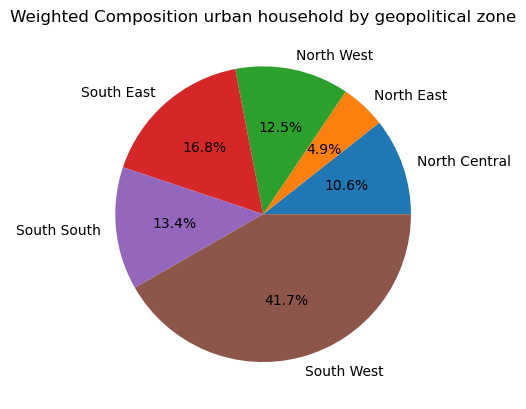

In [26]:
# Weighted 
zone = df2.groupby("zone", observed=True)["hhweightmics"].sum()/df2["hhweightmics"].sum()

labels = zone.index.to_numpy()
values = zone.values

# Create a pie chart of the number of people surveyed in each state
plt.pie(values, labels=labels, autopct="%1.1f%%")
plt.title("Weighted Composition urban household by geopolitical zone")
plt.show()


**Observation**:

* The South West zone has the highest proportion of households at 41.71%. This suggests that a significant portion of the urban population is concentrated in this region.
* The least number of urban household is concentrated in the from the Northern part.

### **Household Characteristics**
In this section will we perform univariate analysis on the household variables. They include the following:

- household home ownership `hh_own_dwelling`
- agricultural land `hh_agricultural_land` and Agricultural land size category `hh_ag_land_size_cat`
- Livestock ownership `hh_own_animal`
- Livestock number `hh_ls_num`
- Source of water `water_source`
- Household size `hh_members_num`
- Number of women `num_of_women_15_49`
- Number of men `num_of_men_15_49`
- Number of child under 5 `num_under_5_child`
- Number of child over 5 `num_5_17_child`

In [27]:
def compute_weighted_proportions_by_one_grp(df, grouping_column, weight_column="hhweightmics"):
    """
    Compute the weighted proportions for each category in the grouping_column
    based on the weights provided in weight_column.
    
    Parameters:
    - df: DataFrame containing the data
    - weight_column: Column name for the weights
    - grouping_column: Column name for the categories to group by
    
    Returns:
    - A Series with proportions for each category
    """
    # Compute the total weight
    total_weight = df[weight_column].sum()
    
    # Compute the weighted proportion for each category
    proportions = (df.groupby(grouping_column, observed=True)[weight_column].sum() * 100) / total_weight
    
    return proportions

##### Household own dwelling

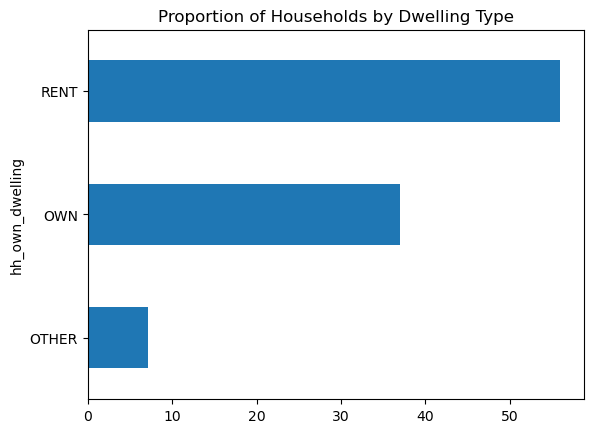

In [28]:

# Compute the weighted proportion for each dwelling type
proportions = compute_weighted_proportions_by_one_grp(df2, "hh_own_dwelling")

proportions.plot(kind="barh", title="Proportion of Households by Dwelling Type");


* The most common home dwelling arrangement in the urban houshold is 'RENT' with more than 50% of the popuplation living in rented homes.
* There is 10 percent the household with OTHER for form of dwelling types. The metadata didn't reveal what OTHER represents.

##### Agricultural land ownership and size

What proportion of urban households own agricultural land and what is the size.

In [29]:
pd.crosstab(df2["hh_agricultural_land"], df2["hh_ag_land_size_cat"])

hh_ag_land_size_cat,0 hectare,1-9 hectares,10 or above
hh_agricultural_land,,,
NO,7142,0,0
YES,65,3174,299


In [30]:
def compute_weighted_proportions_category_col(df, group_col, category_col, weight_col="hhweightmics"):
    """
    Compute weighted proportions of a category column within groups.
    
    Parameters:
    df (pandas.DataFrame): The input DataFrame.
    group_col (str): The column name to group by.
    category_col (str): The column name of the category to compute proportions for.
    weight_col (str): The column name of the weights.
    
    Returns:
    pandas.DataFrame: A DataFrame with the weighted proportions.
    """
    # Compute total weight for each group
    total_weight = df.groupby(group_col, observed=True)[weight_col].sum()
    
    # Compute weighted sum of categories for each group
    weighted_sum = df.groupby([group_col, category_col], observed=True)[weight_col].sum()
    
    # Compute proportions
    result = (weighted_sum / total_weight * 100).reset_index()
    
    # Rename columns for clarity
    result.columns = [group_col, category_col, 'proportion']
    
    return result

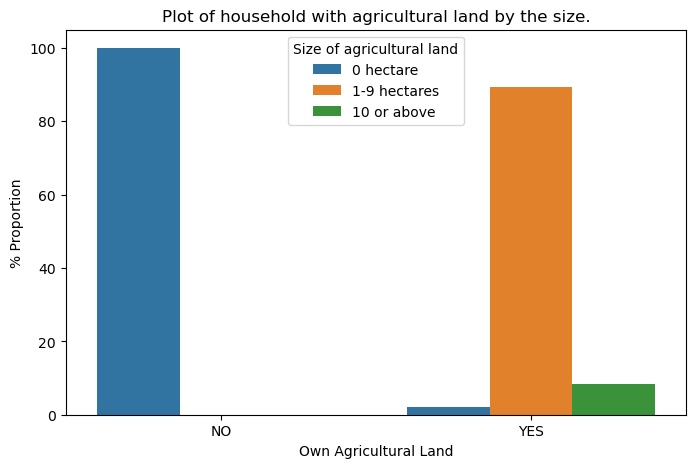

In [31]:

agric_land_by_size = compute_weighted_proportions_category_col(df2, "hh_agricultural_land", "hh_ag_land_size_cat")
# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x='hh_agricultural_land', y='proportion', hue='hh_ag_land_size_cat', data=agric_land_by_size)
plt.title('Plot of household with agricultural land by the size.')
plt.xlabel('Own Agricultural Land')
plt.ylabel('% Proportion')
plt.legend(title='Size of agricultural land')
plt.show()

In [32]:
land_ownership_ratios = compute_weighted_proportions_by_one_grp(df2, "hh_agricultural_land").sort_index(ascending=False)
land_ownership_ratios

hh_agricultural_land
YES    28.330459
NO     71.669541
Name: hhweightmics, dtype: float64

In [33]:
# # Get slice of household with agricultural land only
hh_own_land = df2.query("hh_agricultural_land == 'YES'")

# Calculate the weighted slice(percentage) of households with agricultural land by land size
percent_land_size = eda_utils.calculate_weighted_percentage(hh_own_land, "hh_ag_land_size_cat", "hhweightmics")
percent_land_size

,hh_ag_land_size_cat,weighted_sum,percentage
0,0 hectare,96.107329,0.022
1,1-9 hectares,3937.018113,0.894
2,10 or above,368.358869,0.084


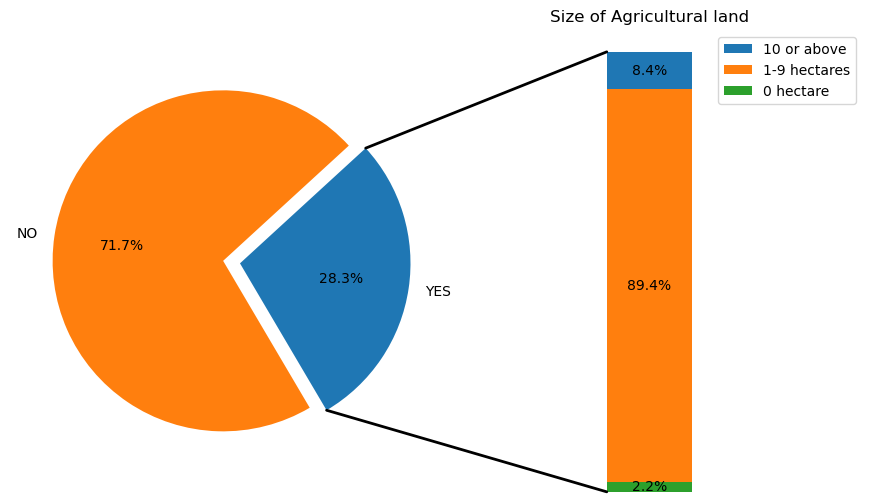

In [34]:
from utils import viz as viz_utils

viz_utils.plot_bar_of_pie(land_ownership_ratios, 
                          percent_land_size, 
                          "hh_ag_land_size_cat",
                          title="Size of Agricultural land")


**Observation**

* 28 percent of the urban households are agricultural land owners. 
* Of the households that own agricultural lands, 89.4% have land size that ranges from 1-9 hectares. 8.4% percent of households have 10 hectares and above.
* 2.2% reported they have 0 hectares. This seems like 'obnormal'/unlikely. However, we will ignore this for now.

It would be insightful to explore a bivariate analysis of with `zone`. Does houshold in the northern part of the country own my land compared to other parts of the country?

The plot below reveals our find:


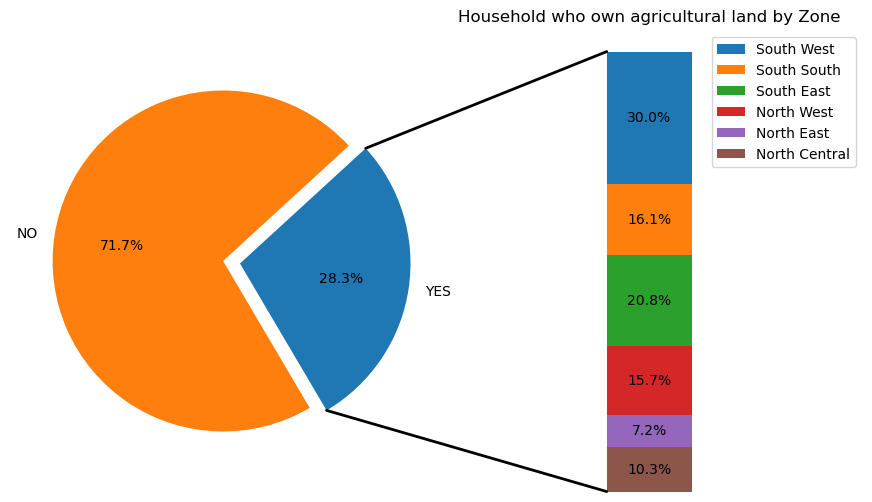

In [35]:
# Get slice of household with agricultural land only
hh_own_land = df2.query("hh_agricultural_land == 'YES'")

# Calculat the weighted slice(percentage) of households with agricultural land by zone
percent_land_by_zone = eda_utils.calculate_weighted_percentage(hh_own_land, "zone", "hhweightmics")


viz_utils.plot_bar_of_pie(land_ownership_ratios, 
                          percent_land_by_zone, 
                          "zone",
                          title="Household who own agricultural land by Zone")

* Household from Southwest and South South reported to own agricultural land compared to other zones.
* Only 10.3 percent of the Households from the North Central, own agricultural land.

##### Household Livestock
The variables related to household livestock are: `hh_ls_num` and `hh_own_animal`

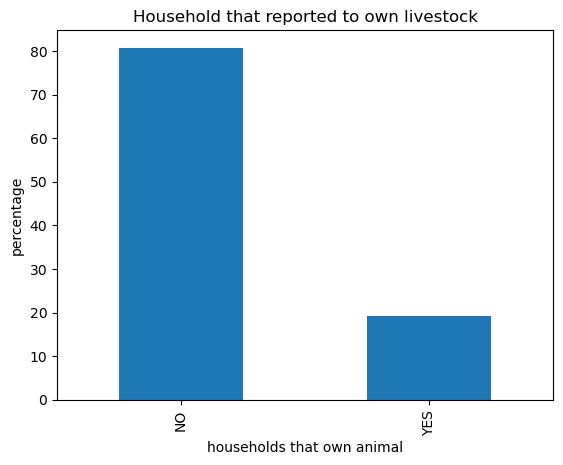

In [36]:
(compute_weighted_proportions_by_one_grp(df2, "hh_own_animal")).plot(kind="bar", 
                                                          title="Household that reported to own livestock",
                                                          xlabel="households that own animal", 
                                                          ylabel="percentage");

In [37]:
print(df2[df2["hh_own_animal"]=="YES"].hh_ls_num.describe())

count    2676.000000
mean       16.501868
std        22.635618
min         1.000000
25%         4.000000
50%         9.000000
75%        20.000000
max       370.000000
Name: hh_ls_num, dtype: float64


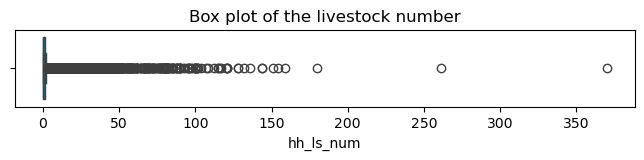

In [38]:
plt.figure(figsize=(8,1))
sns.boxplot(x="hh_ls_num",data=df2)
plt.title("Box plot of the livestock number");

* We can obserse some extreme values. For example, the maximum value of animal is above 300. This an outlier compared to the other records. 
Should handle this outlier. 

**Handle Outlier**
* Based on IQR
* Based on zscore

In [39]:
df2 = eda_utils.outlier_infor_iqr(df2,"hh_ls_num")
df2 = eda_utils.outlier_info_zscore(df2,"hh_ls_num")


Outliers records using IQR:
2272
Outliers records using ZSCORE:
313


* We note that there are actually fewer outliers defined with ZSCORE as using the 1.5 x IQR (Tukey) method. Why is this? The reason for this is that both Tukey’s and the standard score methods assume our data are normally distributed, when in fact they are skewed..Since the data don’t fit the assumptions of the methods we used, we get unexpected results.

Text(0.5, 1.0, 'Boxplot of Livstock Number (zcore)')

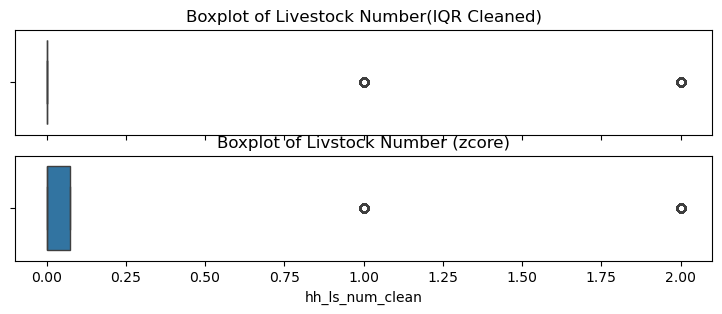

In [40]:
# Plot the distribution of the cleaned variable


fig, axes = plt.subplots(2,1, figsize=(9, 3), sharex=True)
sns.boxplot(df2, x="hh_ls_num_clean_iqr", ax=axes[0])
sns.boxplot(df2, x="hh_ls_num_clean", ax=axes[1])

# Set titles for the subplots
axes[0].set_title("Boxplot of Livestock Number(IQR Cleaned)")
axes[1].set_title("Boxplot of Livstock Number (zcore)")

Let’s generate a box plot of the entire data set, organized by some categorical variables.

/var/folders/v2/zgr5gbws4qd_qpb553947v7h0000gn/T/ipykernel_53132/109791210.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_xticklabels(['NC', 'NE', 'NW', 'SE', 'SS', 'SW'], ha='right')


<Axes: xlabel='urban_wi_quintile_mics', ylabel='hh_ls_num'>

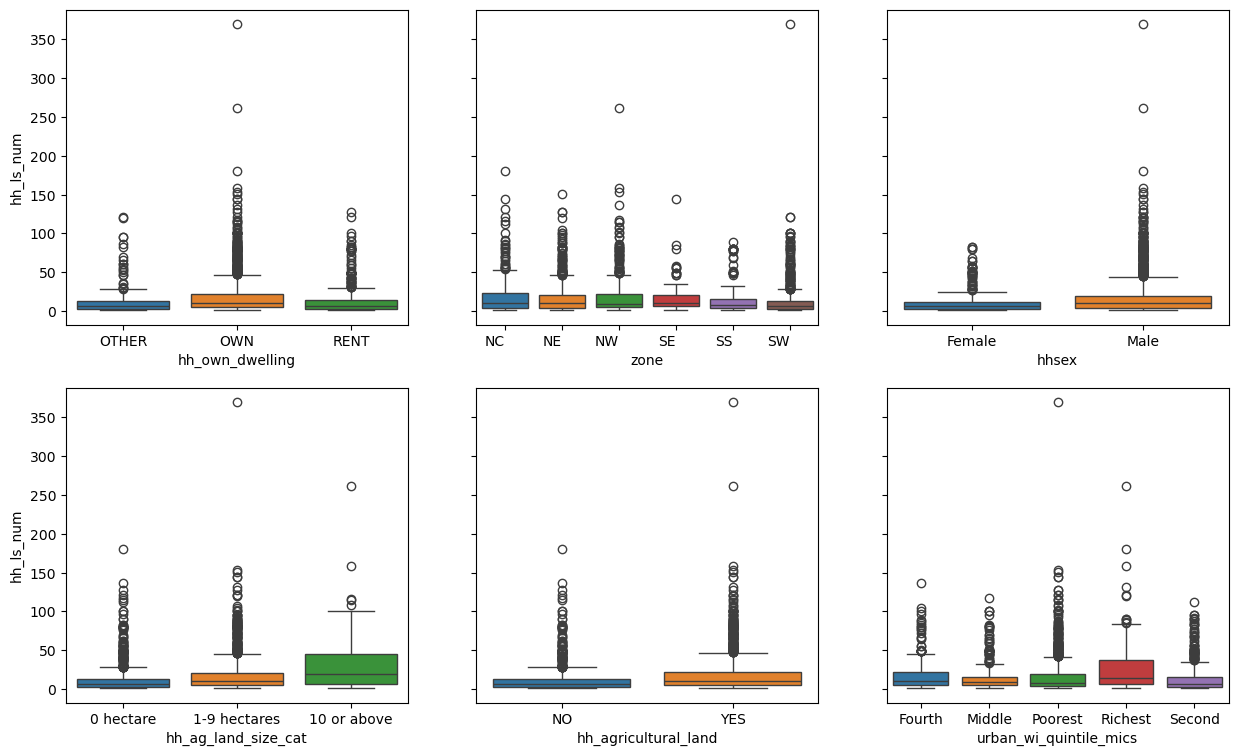

In [41]:

fig, axs = plt.subplots(2,3, figsize=(15, 9), sharey=True)

data_ls = df2[df2["hh_own_animal"]=="YES"].copy()

sns.boxplot(y="hh_ls_num", x="hh_own_dwelling", data=data_ls, hue="hh_own_dwelling", ax=axs[0, 0])
sns.boxplot(y="hh_ls_num", x="zone", data=data_ls, hue="zone", ax=axs[0, 1])
axs[0, 1].set_xticklabels(['NC', 'NE', 'NW', 'SE', 'SS', 'SW'], ha='right')
sns.boxplot(y="hh_ls_num", x="hhsex", data=data_ls, hue="hhsex", ax=axs[0, 2])
sns.boxplot(y="hh_ls_num", x="hh_ag_land_size_cat", data=data_ls, hue="hh_ag_land_size_cat", ax=axs[1, 0])
sns.boxplot(y="hh_ls_num", x="hh_agricultural_land", data=data_ls, hue="hh_agricultural_land", ax=axs[1, 1])
sns.boxplot(y="hh_ls_num", x="urban_wi_quintile_mics", data=data_ls, hue="urban_wi_quintile_mics", ax=axs[1, 2])



* Let’s also look at the distribution of values with a kernel density estimate:

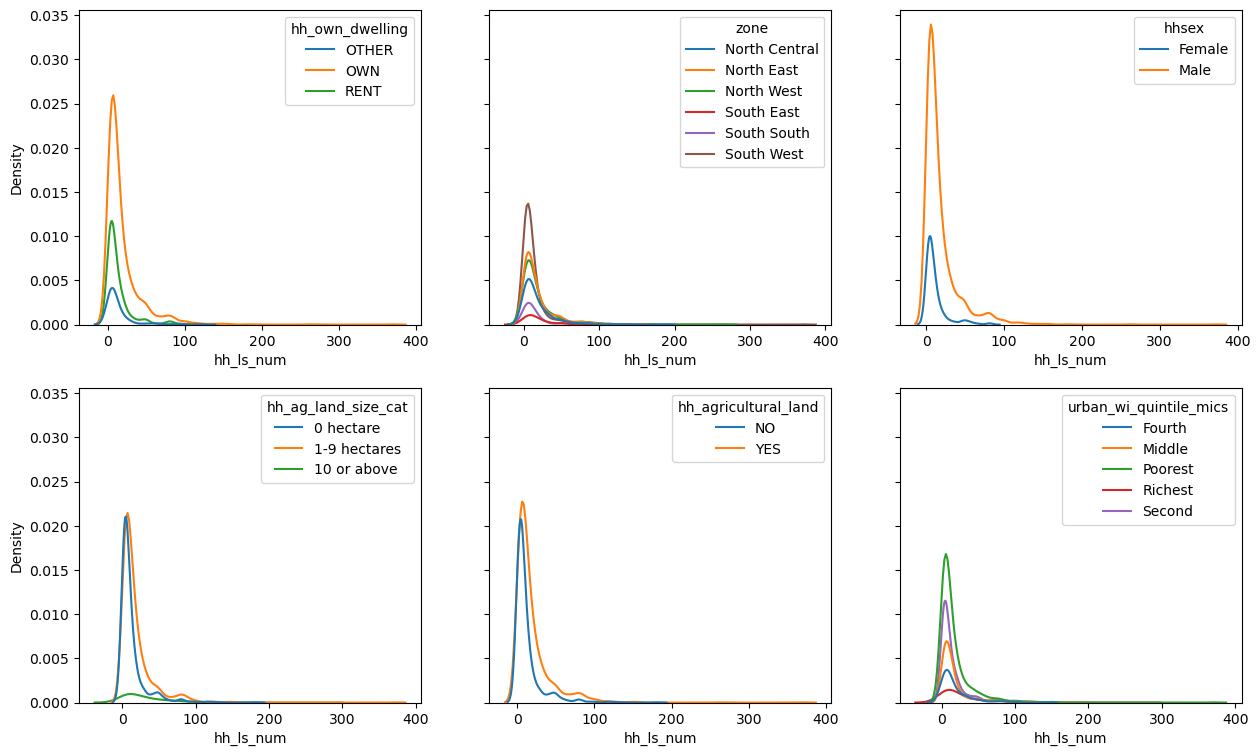

In [42]:
fig, axs = plt.subplots(2,3, figsize=(15, 9), sharey=True)

# data_ls = df2[df2["hh_own_animal"]=="YES"].copy()

sns.kdeplot(x="hh_ls_num", data=data_ls, hue="hh_own_dwelling", ax=axs[0, 0])
sns.kdeplot(x="hh_ls_num", data=data_ls, hue="zone", ax=axs[0, 1])
sns.kdeplot(x="hh_ls_num", data=data_ls, hue="hhsex", ax=axs[0, 2])
sns.kdeplot(x="hh_ls_num", data=data_ls, hue="hh_ag_land_size_cat", ax=axs[1, 0])
sns.kdeplot(x="hh_ls_num", data=data_ls, hue="hh_agricultural_land", ax=axs[1, 1])
sns.kdeplot(x="hh_ls_num", data=data_ls, hue="urban_wi_quintile_mics", ax=axs[1, 2])
plt.show()


* Households that own their dwellings (OWN) have a higher density of livestock numbers compared to those who rent (RENT) or have other types of dwelling ownership (OTHER). This indicates that owning a dwelling might be associated with higher livestock ownership.
* All zones show a similar pattern with the highest density at low livestock numbers, indicating that small-scale livestock ownership is common across all zones. There isn’t a significant difference in the livestock distribution among the zones.
* Households headed by males (Male) have a higher density of livestock numbers compared to those headed by females (Female). This suggests that male-headed households might own more livestock.
* Households with agricultural land sizes between 1-9 hectares have the highest density of livestock numbers, followed by those with 0 hectare and 10 or above. This suggests that small to medium-sized landowners are more likely to own livestock.
*  Households with agricultural land (YES) have a slightly higher density of livestock numbers compared to those without (NO). This indicates that owning agricultural land is positively associated with livestock ownership.
* The Poorest wealth quintile shows the highest density of livestock numbers, followed by Second, Middle, Fourth, and Richest. This suggests that poorer households might rely more on livestock as a source of livelihood.

##### Household Member Size `hh_members_num`

In [43]:
df2["hh_members_num"].describe()

count    10680.000000
mean         4.977715
std          3.316338
min          1.000000
25%          3.000000
50%          5.000000
75%          6.000000
max         31.000000
Name: hh_members_num, dtype: float64

<Axes: xlabel='hh_members_num'>

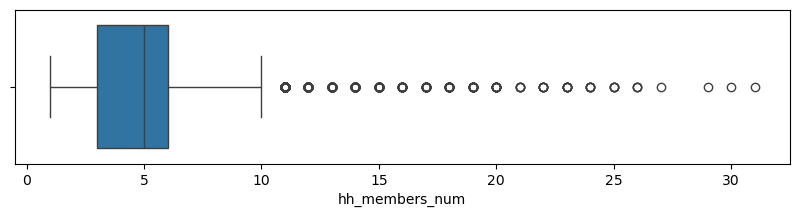

In [44]:
plt.figure(figsize=(10,2))
sns.boxplot(df2, x="hh_members_num")

* There are at least 4 members in each household.
* The number of household members ranges from 1 to 31. This doesn't appear to be abnormal.As this might include members from extended families.
* The boxplot shows that household with members greater than 10 are considered to be outliers. Should we decide to handle this outliers?

**Handle Outlier**

* Based on the IQR, `outlier_infor_iqr()`
* Based on standard z-score: `outlier_info_zscore()`


In [45]:
df2 = eda_utils.outlier_infor_iqr(df2, "hh_members_num")
df2 = eda_utils.outlier_info_zscore(df2, "hh_members_num", z_thresh=2.5)


Outliers records using IQR:
602
Outliers records using ZSCORE:
279


* We note that there are actually fewer outliers defined with ZSCORE as using the 1.5 x IQR (Tukey) method. Why is this? The reason for this is that both Tukey’s and the standard score methods assume our data are normally distributed, when in fact they are skewed..Since the data don’t fit the assumptions of the methods we used, we get unexpected results.

Text(0.5, 1.0, 'Boxplot of Household Members (zcore)')

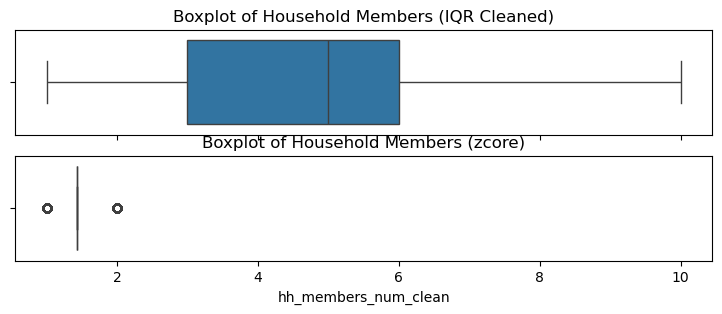

In [46]:
# Plot the distribution of the cleaned variable
fig, axes = plt.subplots(2,1, figsize=(9, 3), sharex=True)
sns.boxplot(df2, x="hh_members_num_clean_iqr", ax=axes[0])
sns.boxplot(df2, x="hh_members_num_clean", ax=axes[1])

# Set titles for the subplots
axes[0].set_title("Boxplot of Household Members (IQR Cleaned)")
axes[1].set_title("Boxplot of Household Members (zcore)")

In [47]:
df2.shape


(10680, 50)

In [48]:
# df2.water_source.value_counts(dropna=False)

### Feature Engineer some new variables
To gain an even deeper insight of the characteristics of the household, we proceed to create some new variables.

In [49]:
# =========== New Variables ======

# Adult household members size = num_of_women_15_49 + num_of_men_15_49
df2 = df2.assign(num_adult = df2["num_of_women_15_49"].add(df2["num_of_men_15_49"]),
                 num_children = df2["num_under_5_child"].add(df2["num_5_17_child"]),
                 hh_siz_cat = np.where(df2["hh_members_num"] > 5, ">5", "<5"),
                 hh_age_cat = pd.cut(df2["hhage"], bins=[15,25, 35, 45, 100 ], 
                                     labels=['16-25', '26-35', '36-45', '>45'])
                )

df2 = df2.assign(hh_num_child_cat = np.where(df2["num_children"] > 1, ">1", "<2"),
                 hh_num_adult_cat = np.where(df2["num_adult"] > 1, ">1", "<2"),)


# Children under 15 y old
# 0–3 children
# ≥4 children

### **Household Head Characteristics**
In this section will we perform univariate analysis on the household head variables. They include the following:

- Gender `hhsex`
- Age `hhage`
- Educational Attainment `helevel`

##### Household Gender
What is the distribution of household gender in within the urban population?


In [50]:
compute_weighted_proportions_by_one_grp(df2, "hhsex")

hhsex
Female    22.598971
Male      77.401029
Name: hhweightmics, dtype: float64

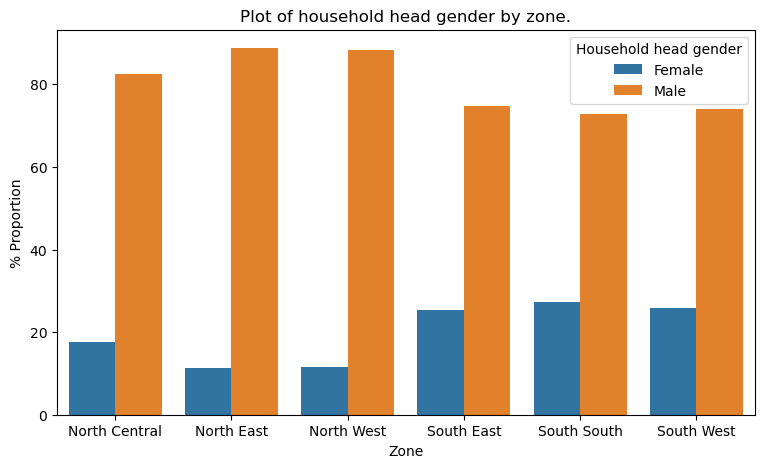

In [51]:
hhsex_by_zone = compute_weighted_proportions_category_col(df2, group_col="zone", category_col="hhsex")

# Plotting
plt.figure(figsize=(9, 5))
sns.barplot(x='zone', y='proportion', hue='hhsex', data=hhsex_by_zone)
plt.title('Plot of household head gender by zone.')
plt.xlabel('Zone')
plt.ylabel('% Proportion')
plt.legend(title='Household head gender')
plt.show()

* In all zones, male-headed households are more prevalent than female-headed households.
* The North East has the lowest proportion of female-headed households at 11.23%, while the South South has the highest at 27.25%.
* The northern zones (North Central, North East, and North West) have a significantly lower proportion of female-headed households compared to the southern zones
* 77.4 percent of the sampled urban household is headed by a male.

##### Household Head Age

In [52]:

# Gender by Age
# Gender by educatioon

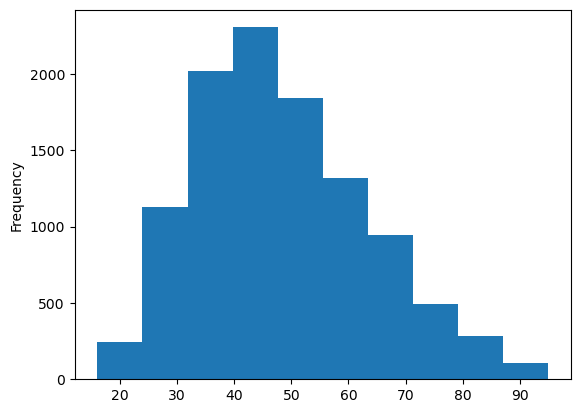

In [53]:
# Is the age variables of urban household normally distributed
df2["hhage"].plot(kind="hist");

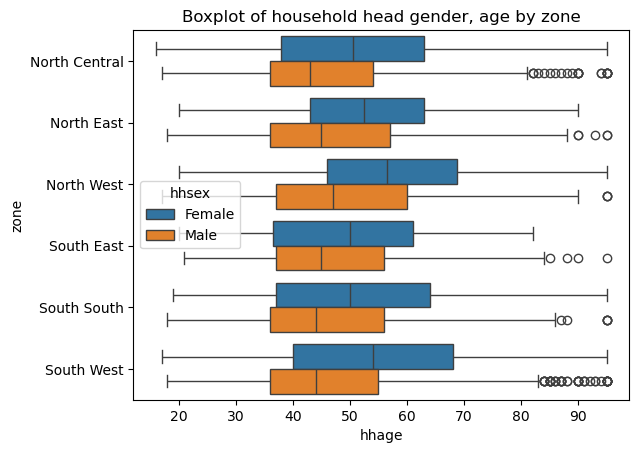

In [54]:
# Draw a vertical boxplot with nested grouping by two hhage and zone
g = sns.boxplot(data=df2, x="hhage", y="zone", hue="hhsex", legend="auto")
g.set_title("Boxplot of household head gender, age by zone");

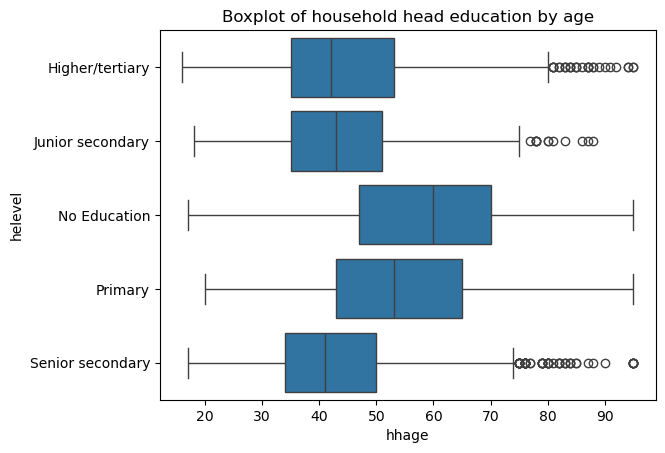

In [55]:
# Draw a vertical boxplot with nested grouping by two hhage and zone
g = sns.boxplot(data=df2, x="hhage", y="helevel", legend="auto")
g.set_title("Boxplot of household head education by age");

* The younger household head attain higher education compared to the older hh head.
* In all zones, female household head are older on averaged compared to their male counterpart.
* Age is relatively normally distributed

##### Household Head Education `helevel`

In [56]:
# What is the proportion of educated head of household in the population?
compute_weighted_proportions_by_one_grp(df2, "helevel")


helevel
Higher/tertiary     29.952778
Junior secondary     4.334815
No Education        14.138210
Primary             17.659098
Senior secondary    33.915099
Name: hhweightmics, dtype: float64

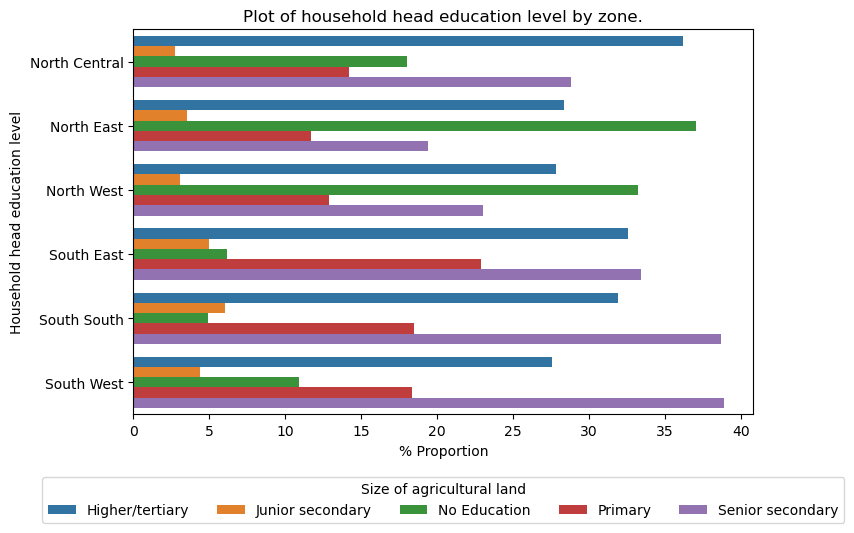

In [57]:
# What is the proportion of education head of house by zone
edu_by_zone = compute_weighted_proportions_category_col(df2, "zone","helevel")

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x='proportion', y='zone', hue='helevel', data=edu_by_zone, orient="h")
plt.title('Plot of household head education level by zone.')
plt.ylabel('Household head education level')
plt.xlabel('% Proportion')
plt.legend(title='Size of agricultural land',ncols=5, loc="lower center", bbox_to_anchor=(0.5, -0.3))
plt.show()

* North Eastern part of the country presents more household head with no education. Southern part presents the least number of household head with no education. 

In [58]:
df2.head(4)

,hh1,hh2,area,zone,hh_members_num,num_of_women_15_49,num_of_men_15_49,num_under_5_child,num_5_17_child,hhsex,hhage,helevel,hh_own_dwelling,hh_agricultural_land,hh_own_animal,hh_mn_attended_sch_num,hh_mn_mean_age_yrs,hh_mn_attended_atleast_sec_sch,hh_mn_mean_life_satisfaction,hh_wm_attended_sch_num,hh_wm_mean_age_yrs,hh_wm_attended_atleast_sec_sch,hh_wm_mean_life_satisfaction,water_source,wi_quintile_mics,wscoremics,urban_wi_quintile_mics,hh_ls_num,fies_score,hhweightmics,psu,stratum,prob_mod_sev,prob_sev,rs_fies_score,WORRIED,HEALTHY,FEWFOOD,SKIPPED,ATELESS,RANOUT,HUNGRY,WHLDAY,hh_ag_land_size_cat,agg_wealth_index,cluster_wi_category,hh_ls_num_clean_iqr,hh_ls_num_clean,hh_members_num_clean_iqr,hh_members_num_clean,num_adult,num_children,hh_siz_cat,hh_age_cat,hh_num_child_cat,hh_num_adult_cat
0,1.0,1.0,URBAN,South East,4.0,3.0,0.0,0.0,1.0,Female,46.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,3.0,28.666667,2.0,3.333333,TUBE WELL / BOREHOLE,Fourth,0.839976,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare,1.002562,High,0.0,0.000000,4.0,1.43299,3.0,1.0,<5,>45,<2,>1
1,1.0,2.0,URBAN,South East,2.0,2.0,0.0,0.0,1.0,Female,45.0,Senior secondary,RENT,NO,NO,0.0,0.0,0.0,0.0,2.0,30.500000,2.0,5.500000,TUBE WELL / BOREHOLE,Fourth,0.695187,Second,0,6,0.61955,1.0,1.0,0.971,0.043,6,1,1,1,1,1,1,0,0,0 hectare,1.002562,High,0.0,0.000000,2.0,2.00000,2.0,1.0,<5,36-45,<2,>1
2,1.0,3.0,URBAN,South East,5.0,1.0,0.0,2.0,1.0,Male,41.0,Senior secondary,OWN,NO,YES,0.0,0.0,0.0,0.0,1.0,34.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,1.031051,Middle,30,5,0.61955,1.0,1.0,0.875,0.002,5,1,0,0,1,1,1,1,0,0 hectare,1.002562,High,0.0,0.074929,5.0,1.43299,1.0,3.0,<5,36-45,>1,<2
3,1.0,4.0,URBAN,South East,4.0,1.0,1.0,0.0,0.0,Male,81.0,No Education,OWN,YES,YES,1.0,33.0,1.0,5.0,1.0,38.000000,1.0,8.000000,TUBE WELL / BOREHOLE,Middle,-0.190450,Poorest,144,7,0.61955,1.0,1.0,0.995,0.390,7,0,1,1,1,1,1,1,1,1-9 hectares,1.002562,High,0.0,0.074929,4.0,1.43299,2.0,0.0,<5,>45,<2,>1


## **Food Insecurity Experience Scale (FIES) of Urban Household**

We already performed the [statistical validation ](notebooks/2_rasch_model_urban.ipynb) needed to ensure that the collected data is appropiate to measure comparable food insecurity.

Based on the FIES questions, we adopt several approaches to measure food insecurity. 

1. Households’ classification into **moderate or severe insecurity**(`FI_mod_sev`) follows the parametric analysis and procedure outlined by FAO and using the analytical tool: [https://fies.shinyapps.io/ExtendedApp/](https://fies.shinyapps.io/ExtendedApp/). This is also known as **probabilistic** approach

2. Second,(**Discrete Approach**) we use the raw values of the responses and associated “raw score” which we generate by summing the responses to the eight questions. The raw value of these responses assumes binary nature while the raw score assumes a value between zero and eight. By this definition, those households reporting experience of food insecurity across one or more of the eight dimensions are assumed to be facing food insecurity.



### **Composition of the `fies_rawscore`**


Raw score is ordinal (probabilistically) with respect to the latent trait of food insecurity. As such, it can be used to classify households within a country as to food insecurity status. (Such classification may not represent equal levels of severity between countries, however.) Raw score is NOT an interval measure, so it should *not be used to calculate a mean or in linear regression models*

The possible responses in each question in the FIES include “Yes” scored as 1, “No” scored as 0 and “Don’t know” scored as DK. Raw house-
hold FI scores (0–8) were computed as the total number of affirmative responses.

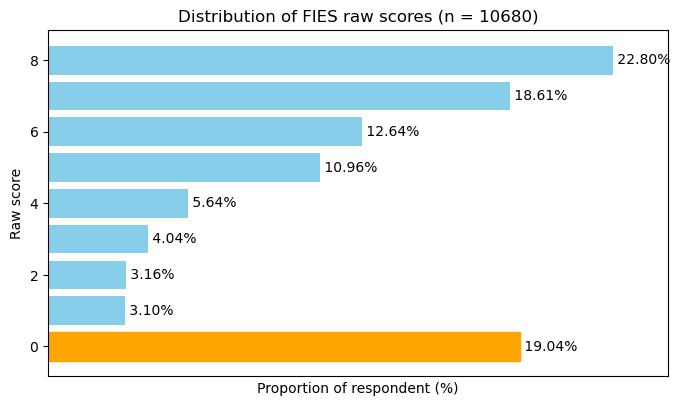

In [59]:
percent_fies_score = (df2["fies_score"].value_counts(normalize=True) * 100).sort_index()

plt.figure(figsize=(7,4))
ax = plt.barh(percent_fies_score.index, percent_fies_score, color='skyblue')

# Annotating the bars with count values
for i, v in enumerate(percent_fies_score):
    plt.text(v, i, f' {percent_fies_score.values[i]:.2f}%', va='center')

# Highlighting the bar with raw score value of 0
raw_score_0_index = percent_fies_score.index.get_loc(0)
ax[raw_score_0_index].set_color('orange')  

# Adding more space around the plot
plt.tight_layout()
plt.title(f"Distribution of FIES raw scores (n = {len(df2["fies_score"])})")
plt.xlabel("Proportion of respondent (%)")
plt.ylabel("Raw score")
plt.xlim((0, 25))
# plt.grid(True, axis="x")
plt.xticks([], []);

* Valid FIES question/response: 10,680, Minimum: 0 Maximum: 8
* The figure show the distribution of the raw scores in our data:
> * 19.04% respondents had a raw score of 0. ie, they did not experience any of the assessed recent food insecurity(RFI). In the framework of the FIES they are considered **Food Secure**.

**Impact**

* Recent food insecurity (RFI) is defined by a raw score greater than 0, meaning that at least one of the eight FIES questions had been answered with YES.




### 1. **Prevalance of Food Insecurity (Probabilistic assignment) Approach**

Estimating the prevalence of food insecurity in the population involves two general steps.

1. Define thresholds along the scale (levels of severity) that will define classes of food security.
2. Calculate the percentage of ihouseholds in the population expected (or "likely") to
be food insecure at severity levels in excess of the threshold.

#### 1. Define thresholds along the scale (levels of severity) that will define classes of food security.


ATELESS and WHLDAY is selected to set the two threshold as recommended by [Using the Food Insecurity Experience
Scale (FIES)](https://elearning.fao.org/pluginfile.php/491591/mod_scorm/content/5/story_content/external_files/SDG2.1.2_lesson4.pdf):

The first threshold is set at the severity level of the FIES item `ATELESS`, and separates the class of "food secure or mildly food insecure" from the class of "moderately food insecure" (`PFI_mod_sev`). The second threshold is set at the severity level of the FIES item `WHLDAY`and separates the class of "moderately food insecure" from that of the "severely food insecure" (`PFI_sev`). 
Based on previous analysis, `ATELESS` and `WHLDAY` have a adjusted threshold of -0.54 and 3.24 respectively.


<center>
<img src="../assets/shiny_app_raw_score_params.png" width="200" />
<figcaption style="font-size: 10px; font-style: italic;">Rawscore statistics</figcaption>
</center>



* `PFI_mid_moderate` : 1 if Respondent rawscore `Severity` is less than -0.54 , 0 otherwise.
* `PFI_mod_sev`: 1 if rawscore `Severity` greater or equal to -0.54 and less than 3.24, 0 otherwise.
* `PFI_sev`: 1 if rawscore `Severity` is greater than 3.24 , 0 otherwise.



In [60]:
df2 = df2.assign(
    PFI_moderate_severe = np.where((df2["fies_score"] >= 4) & (df2["fies_score"] < 8), 1, 0),
    PFI_severe = np.where(df2["fies_score"] > 7, 1, 0),
    PFI_mid_moderate = np.where(df2["fies_score"] < 4, 1, 0),
    
)
df2.shape

(10680, 59)

**Impact**

Based on this approach, we end up with 3 sets of food insecurity indicators: 

* `FI_mod_sev`: a binary indicator of experience of moderate or severe food insecurity based on severity of food insecurity
* `FI_mid_moderate`: a binary indicator of experience of midly or moderate food insecurity based on severity of food insecurity
* `FI_sev`: a binary indicator of experience of ssevere food insecurity based on severity of food insecurity


#### 2. Estimating the prevalence of food insecurity in the urban housholds/population

By **prevalence** We mean the percentage of individuals in the total population who are affected by food insecurity at different levels of severity. It is important to keep in mind that this percentage is not simply the proportion of food insecure individuals or households in the sample that has been surveyed. Sampling weights must is applied to account for unequal sampling, and to ensure that the prevalence rates reported reflect the proportion of food insecure individuals or households in the population


In [61]:
df2.head()

,hh1,hh2,area,zone,hh_members_num,num_of_women_15_49,num_of_men_15_49,num_under_5_child,num_5_17_child,hhsex,hhage,helevel,hh_own_dwelling,hh_agricultural_land,hh_own_animal,hh_mn_attended_sch_num,hh_mn_mean_age_yrs,hh_mn_attended_atleast_sec_sch,hh_mn_mean_life_satisfaction,hh_wm_attended_sch_num,hh_wm_mean_age_yrs,hh_wm_attended_atleast_sec_sch,hh_wm_mean_life_satisfaction,water_source,wi_quintile_mics,wscoremics,urban_wi_quintile_mics,hh_ls_num,fies_score,hhweightmics,psu,stratum,prob_mod_sev,prob_sev,rs_fies_score,WORRIED,HEALTHY,FEWFOOD,SKIPPED,ATELESS,RANOUT,HUNGRY,WHLDAY,hh_ag_land_size_cat,agg_wealth_index,cluster_wi_category,hh_ls_num_clean_iqr,hh_ls_num_clean,hh_members_num_clean_iqr,hh_members_num_clean,num_adult,num_children,hh_siz_cat,hh_age_cat,hh_num_child_cat,hh_num_adult_cat,PFI_moderate_severe,PFI_severe,PFI_mid_moderate
0,1.0,1.0,URBAN,South East,4.0,3.0,0.0,0.0,1.0,Female,46.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,3.0,28.666667,2.0,3.333333,TUBE WELL / BOREHOLE,Fourth,0.839976,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare,1.002562,High,0.0,0.000000,4.0,1.43299,3.0,1.0,<5,>45,<2,>1,1,0,0
1,1.0,2.0,URBAN,South East,2.0,2.0,0.0,0.0,1.0,Female,45.0,Senior secondary,RENT,NO,NO,0.0,0.0,0.0,0.0,2.0,30.500000,2.0,5.500000,TUBE WELL / BOREHOLE,Fourth,0.695187,Second,0,6,0.61955,1.0,1.0,0.971,0.043,6,1,1,1,1,1,1,0,0,0 hectare,1.002562,High,0.0,0.000000,2.0,2.00000,2.0,1.0,<5,36-45,<2,>1,1,0,0
2,1.0,3.0,URBAN,South East,5.0,1.0,0.0,2.0,1.0,Male,41.0,Senior secondary,OWN,NO,YES,0.0,0.0,0.0,0.0,1.0,34.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,1.031051,Middle,30,5,0.61955,1.0,1.0,0.875,0.002,5,1,0,0,1,1,1,1,0,0 hectare,1.002562,High,0.0,0.074929,5.0,1.43299,1.0,3.0,<5,36-45,>1,<2,1,0,0
3,1.0,4.0,URBAN,South East,4.0,1.0,1.0,0.0,0.0,Male,81.0,No Education,OWN,YES,YES,1.0,33.0,1.0,5.0,1.0,38.000000,1.0,8.000000,TUBE WELL / BOREHOLE,Middle,-0.190450,Poorest,144,7,0.61955,1.0,1.0,0.995,0.390,7,0,1,1,1,1,1,1,1,1-9 hectares,1.002562,High,0.0,0.074929,4.0,1.43299,2.0,0.0,<5,>45,<2,>1,1,0,0
4,1.0,5.0,URBAN,South East,5.0,1.0,0.0,0.0,1.0,Male,63.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,1.0,23.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,0.999549,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare,1.002562,High,0.0,0.000000,5.0,1.43299,1.0,1.0,<5,>45,<2,<2,1,0,0


In [62]:
# Group by 'fies_score' and calculate the required metrics in one step

threshold_mod_sev_fi = df2.groupby("fies_score", observed=True).agg(
    percent_hh_rawscore=("fies_score", lambda x: len(x) / len(df2) * 100),
    prob_mod_sev=("prob_mod_sev", "mean"),
    prob_sev=("prob_sev", "mean")
).reset_index()

# Display the hresholds of Moderate and Severe and Severe food insecurity
threshold_mod_sev_fi


,fies_score,percent_hh_rawscore,prob_mod_sev,prob_sev
0,0,19.044944,0.000,0.000
1,1,3.099251,0.022,0.000
2,2,3.155431,0.085,0.000
3,3,4.044944,0.284,0.000
4,4,5.636704,0.616,0.000
5,5,10.964419,0.875,0.002
6,6,12.640449,0.971,0.043
7,7,18.614232,0.995,0.390
8,8,22.799625,1.000,0.821


**The Prevalance of Urban Household Food insecurity**

In [63]:
# Compute the prevalence rate for moderate severity
Moderate_sev_FI = (threshold_mod_sev_fi["percent_hh_rawscore"] * threshold_mod_sev_fi["prob_mod_sev"]).sum()

# Compute the prevalence rate for severe severity
sev_FI = (threshold_mod_sev_fi["percent_hh_rawscore"] * threshold_mod_sev_fi["prob_sev"]).sum()

# Display the results
Moderate_sev_FI, sev_FI


(68.14589887640449, 26.543511235955055)

* On avearage(weighted) 68% of the households are experiencing moderate or severe `FI_mod_sev` food insecurity when taking into account the proportions of households at different `fies_score` levels and their corresponding probabilities of moderate food insecurity.

* Severe Prevalence (27%): This indicates that, on average, about 27% of the households are experiencing severe food insecurity.

**Impact**
* This result is similar to what is obtained from [FIES Shiny App]( https://fies.shinyapps.io/ExtendedApp/). Likewise the result from using `R.weight` methods

<center>
<img src="../assets/shiny_app_foa_voh_urban_fi_prevalance.png" width="700" />
<!-- <figcaption style="font-size: 10px; font-style: italic;">Fig. 1: Relative scale of severity</figcaption> -->
</center>

### Map of Prevalence of Food Insecurity levels by Zone


In [64]:
# melted_df = df2.melt(id_vars=["zone", "fies_score"], 
#                      var_name = "indicator",
#                      value_vars=["prob_mod_sev", "prob_sev"],
#                      value_name="probability")

# melted_df = df2.melt(id_vars=["zone", "fies_score"], 
#                      var_name = "indicator",
#                      value_vars=["prob_mod_sev", "prob_sev"],
#                      value_name="probability")
# melted_df["weighted_proba"] = melted_df["probability"].mul(melted_df["fies_score"])
# total_weight = df2.groupby(["zone"], observed=True)["fies_score"].sum()

# weighted_sum = melted_df.groupby(["zone", "indicator"], observed=True)["weighted_proba"].sum()

# result =(weighted_sum*100/total_weight).reset_index()
# result.columns = ["zone", "indicator", 'proportion']


In [65]:
# Utitily function to conduction Bivariate Analysis
# Btw probability of respondent ebeing moderate or severe level
# and severe level of food insecurity
def calculate_weighted_proportion_fies(df, grp_col, fi_mod_col="prob_mod_sev", fi_sev_col="prob_sev", wt="hhweightmics"):
    """
    Calculate the weighted proportion of two indicators (eg `prob_mod_sev` and `prob_sev`) by `grp_col` e.g zone

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the data.
    wt : str
        The column name for the weight variable.
    grp_col : str
        The column name to group by, e.g., 'zone'.

    Returns
    -------
    pandas.DataFrame
        A DataFrame with the aggregated results.
    """

    # Melt the DataFrame
    melted_df = df2.melt(id_vars=[grp_col, wt], 
                     var_name = "indicator",
                     value_vars=[fi_mod_col, fi_sev_col],
                     value_name="probability")
    
    melted_df["weighted_proba"] = melted_df["probability"].mul(melted_df[wt])
    
    # calculate the total weight for each zone.
    total_weight = df2.groupby(["zone"], observed=True)["hhweightmics"].sum()

    # calculate the total weighted probability for each combination of zone and indicator
    weighted_sum = melted_df.groupby([grp_col, "indicator"], observed=True)["weighted_proba"].sum()
    
    result =(weighted_sum*100/total_weight).reset_index()
    # meaningful names to the columns in the final result.
    result.columns = ["zone", "indicator", 'proportion']
    return result

In [66]:
df2.head()

,hh1,hh2,area,zone,hh_members_num,num_of_women_15_49,num_of_men_15_49,num_under_5_child,num_5_17_child,hhsex,hhage,helevel,hh_own_dwelling,hh_agricultural_land,hh_own_animal,hh_mn_attended_sch_num,hh_mn_mean_age_yrs,hh_mn_attended_atleast_sec_sch,hh_mn_mean_life_satisfaction,hh_wm_attended_sch_num,hh_wm_mean_age_yrs,hh_wm_attended_atleast_sec_sch,hh_wm_mean_life_satisfaction,water_source,wi_quintile_mics,wscoremics,urban_wi_quintile_mics,hh_ls_num,fies_score,hhweightmics,psu,stratum,prob_mod_sev,prob_sev,rs_fies_score,WORRIED,HEALTHY,FEWFOOD,SKIPPED,ATELESS,RANOUT,HUNGRY,WHLDAY,hh_ag_land_size_cat,agg_wealth_index,cluster_wi_category,hh_ls_num_clean_iqr,hh_ls_num_clean,hh_members_num_clean_iqr,hh_members_num_clean,num_adult,num_children,hh_siz_cat,hh_age_cat,hh_num_child_cat,hh_num_adult_cat,PFI_moderate_severe,PFI_severe,PFI_mid_moderate
0,1.0,1.0,URBAN,South East,4.0,3.0,0.0,0.0,1.0,Female,46.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,3.0,28.666667,2.0,3.333333,TUBE WELL / BOREHOLE,Fourth,0.839976,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare,1.002562,High,0.0,0.000000,4.0,1.43299,3.0,1.0,<5,>45,<2,>1,1,0,0
1,1.0,2.0,URBAN,South East,2.0,2.0,0.0,0.0,1.0,Female,45.0,Senior secondary,RENT,NO,NO,0.0,0.0,0.0,0.0,2.0,30.500000,2.0,5.500000,TUBE WELL / BOREHOLE,Fourth,0.695187,Second,0,6,0.61955,1.0,1.0,0.971,0.043,6,1,1,1,1,1,1,0,0,0 hectare,1.002562,High,0.0,0.000000,2.0,2.00000,2.0,1.0,<5,36-45,<2,>1,1,0,0
2,1.0,3.0,URBAN,South East,5.0,1.0,0.0,2.0,1.0,Male,41.0,Senior secondary,OWN,NO,YES,0.0,0.0,0.0,0.0,1.0,34.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,1.031051,Middle,30,5,0.61955,1.0,1.0,0.875,0.002,5,1,0,0,1,1,1,1,0,0 hectare,1.002562,High,0.0,0.074929,5.0,1.43299,1.0,3.0,<5,36-45,>1,<2,1,0,0
3,1.0,4.0,URBAN,South East,4.0,1.0,1.0,0.0,0.0,Male,81.0,No Education,OWN,YES,YES,1.0,33.0,1.0,5.0,1.0,38.000000,1.0,8.000000,TUBE WELL / BOREHOLE,Middle,-0.190450,Poorest,144,7,0.61955,1.0,1.0,0.995,0.390,7,0,1,1,1,1,1,1,1,1-9 hectares,1.002562,High,0.0,0.074929,4.0,1.43299,2.0,0.0,<5,>45,<2,>1,1,0,0
4,1.0,5.0,URBAN,South East,5.0,1.0,0.0,0.0,1.0,Male,63.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,1.0,23.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,0.999549,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare,1.002562,High,0.0,0.000000,5.0,1.43299,1.0,1.0,<5,>45,<2,<2,1,0,0


In [67]:
prevalence_by_zone= calculate_weighted_proportion_fies(df2, grp_col="zone")
prevalence_by_zone

,zone,indicator,proportion
0,North Central,prob_mod_sev,74.728753
1,North Central,prob_sev,27.239415
2,North East,prob_mod_sev,65.602207
3,North East,prob_sev,31.024370
4,North West,prob_mod_sev,68.485975
5,North West,prob_sev,27.402600
6,South East,prob_mod_sev,75.273935
7,South East,prob_sev,26.673541
8,South South,prob_mod_sev,67.597466
9,South South,prob_sev,22.129529


In [68]:
# Load shapefile of Nigeria
# file = open("../../../data/DIEM_NG/DIEM_household_surveys_microdata.geojson")
file = open("../assets/nigeria_geojson.geojson")


gdf = gpd.read_file(file)

In [69]:
gdf = gdf.rename(columns = {"geozone": "zone"})

gdf = gdf.replace({"NCZ": "North Central", "NWZ": "North West",
                   "SWZ": "South West", "SSZ": "South South",
                  "NEZ": "North East", "SEZ": "South East"})


In [81]:
gdf.head()

,objectid,statecode,state,capcity,source,timestamp,globalid,shape_area,shape_len,zone,cartodb_id,created_at,updated_at,geometry
0,1244,FC,"Fct, Abuja",Abuja,WHO,1855851096,{0E73256C-2793-44CC-AB1B-7289F145B866},0.615036531209321,3.50286601145588,North Central,3,2015-04-03 18:35:50+00:00,2015-04-03 18:35:50+00:00,"MULTIPOLYGON (((7.69297 9.34940, 7.72092 9.330..."
1,1250,BE,Benue,Makurdi,WHO,1855851096,{349B514B-6EC6-4311-B8E8-C253A42347D1},2.521804258376,9.05867380560905,North Central,6,2015-04-03 18:35:50+00:00,2015-04-03 18:35:50+00:00,"MULTIPOLYGON (((8.84186 8.06709, 8.91085 8.056..."
2,1251,OS,Osun,Oshogbo,WHO,1855851096,{05FC3E53-CE0A-491D-9B37-2E9F1E3651FB},0.700545839562164,4.55006612819726,South West,7,2015-04-03 18:35:50+00:00,2015-04-03 18:35:50+00:00,"MULTIPOLYGON (((4.94975 8.05548, 4.96080 8.052..."
3,1253,IM,Imo,Owerri,WHO,1855851096,{D4BEA7A2-3D76-4985-938C-61DD493BE2CB},0.41903873752378,2.78702712967015,South East,9,2015-04-03 18:35:50+00:00,2015-04-03 18:35:50+00:00,"MULTIPOLYGON (((7.26463 5.93230, 7.26745 5.928..."
4,1254,DE,Delta,Asaba,WHO,1855851096,{99C8D1D1-4342-41F3-8E59-E293FB7B6ACB},1.36119458474685,8.78236707514049,South South,10,2015-04-03 18:35:50+00:00,2015-04-03 18:35:50+00:00,"MULTIPOLYGON (((6.66892 6.50123, 6.67111 6.484..."


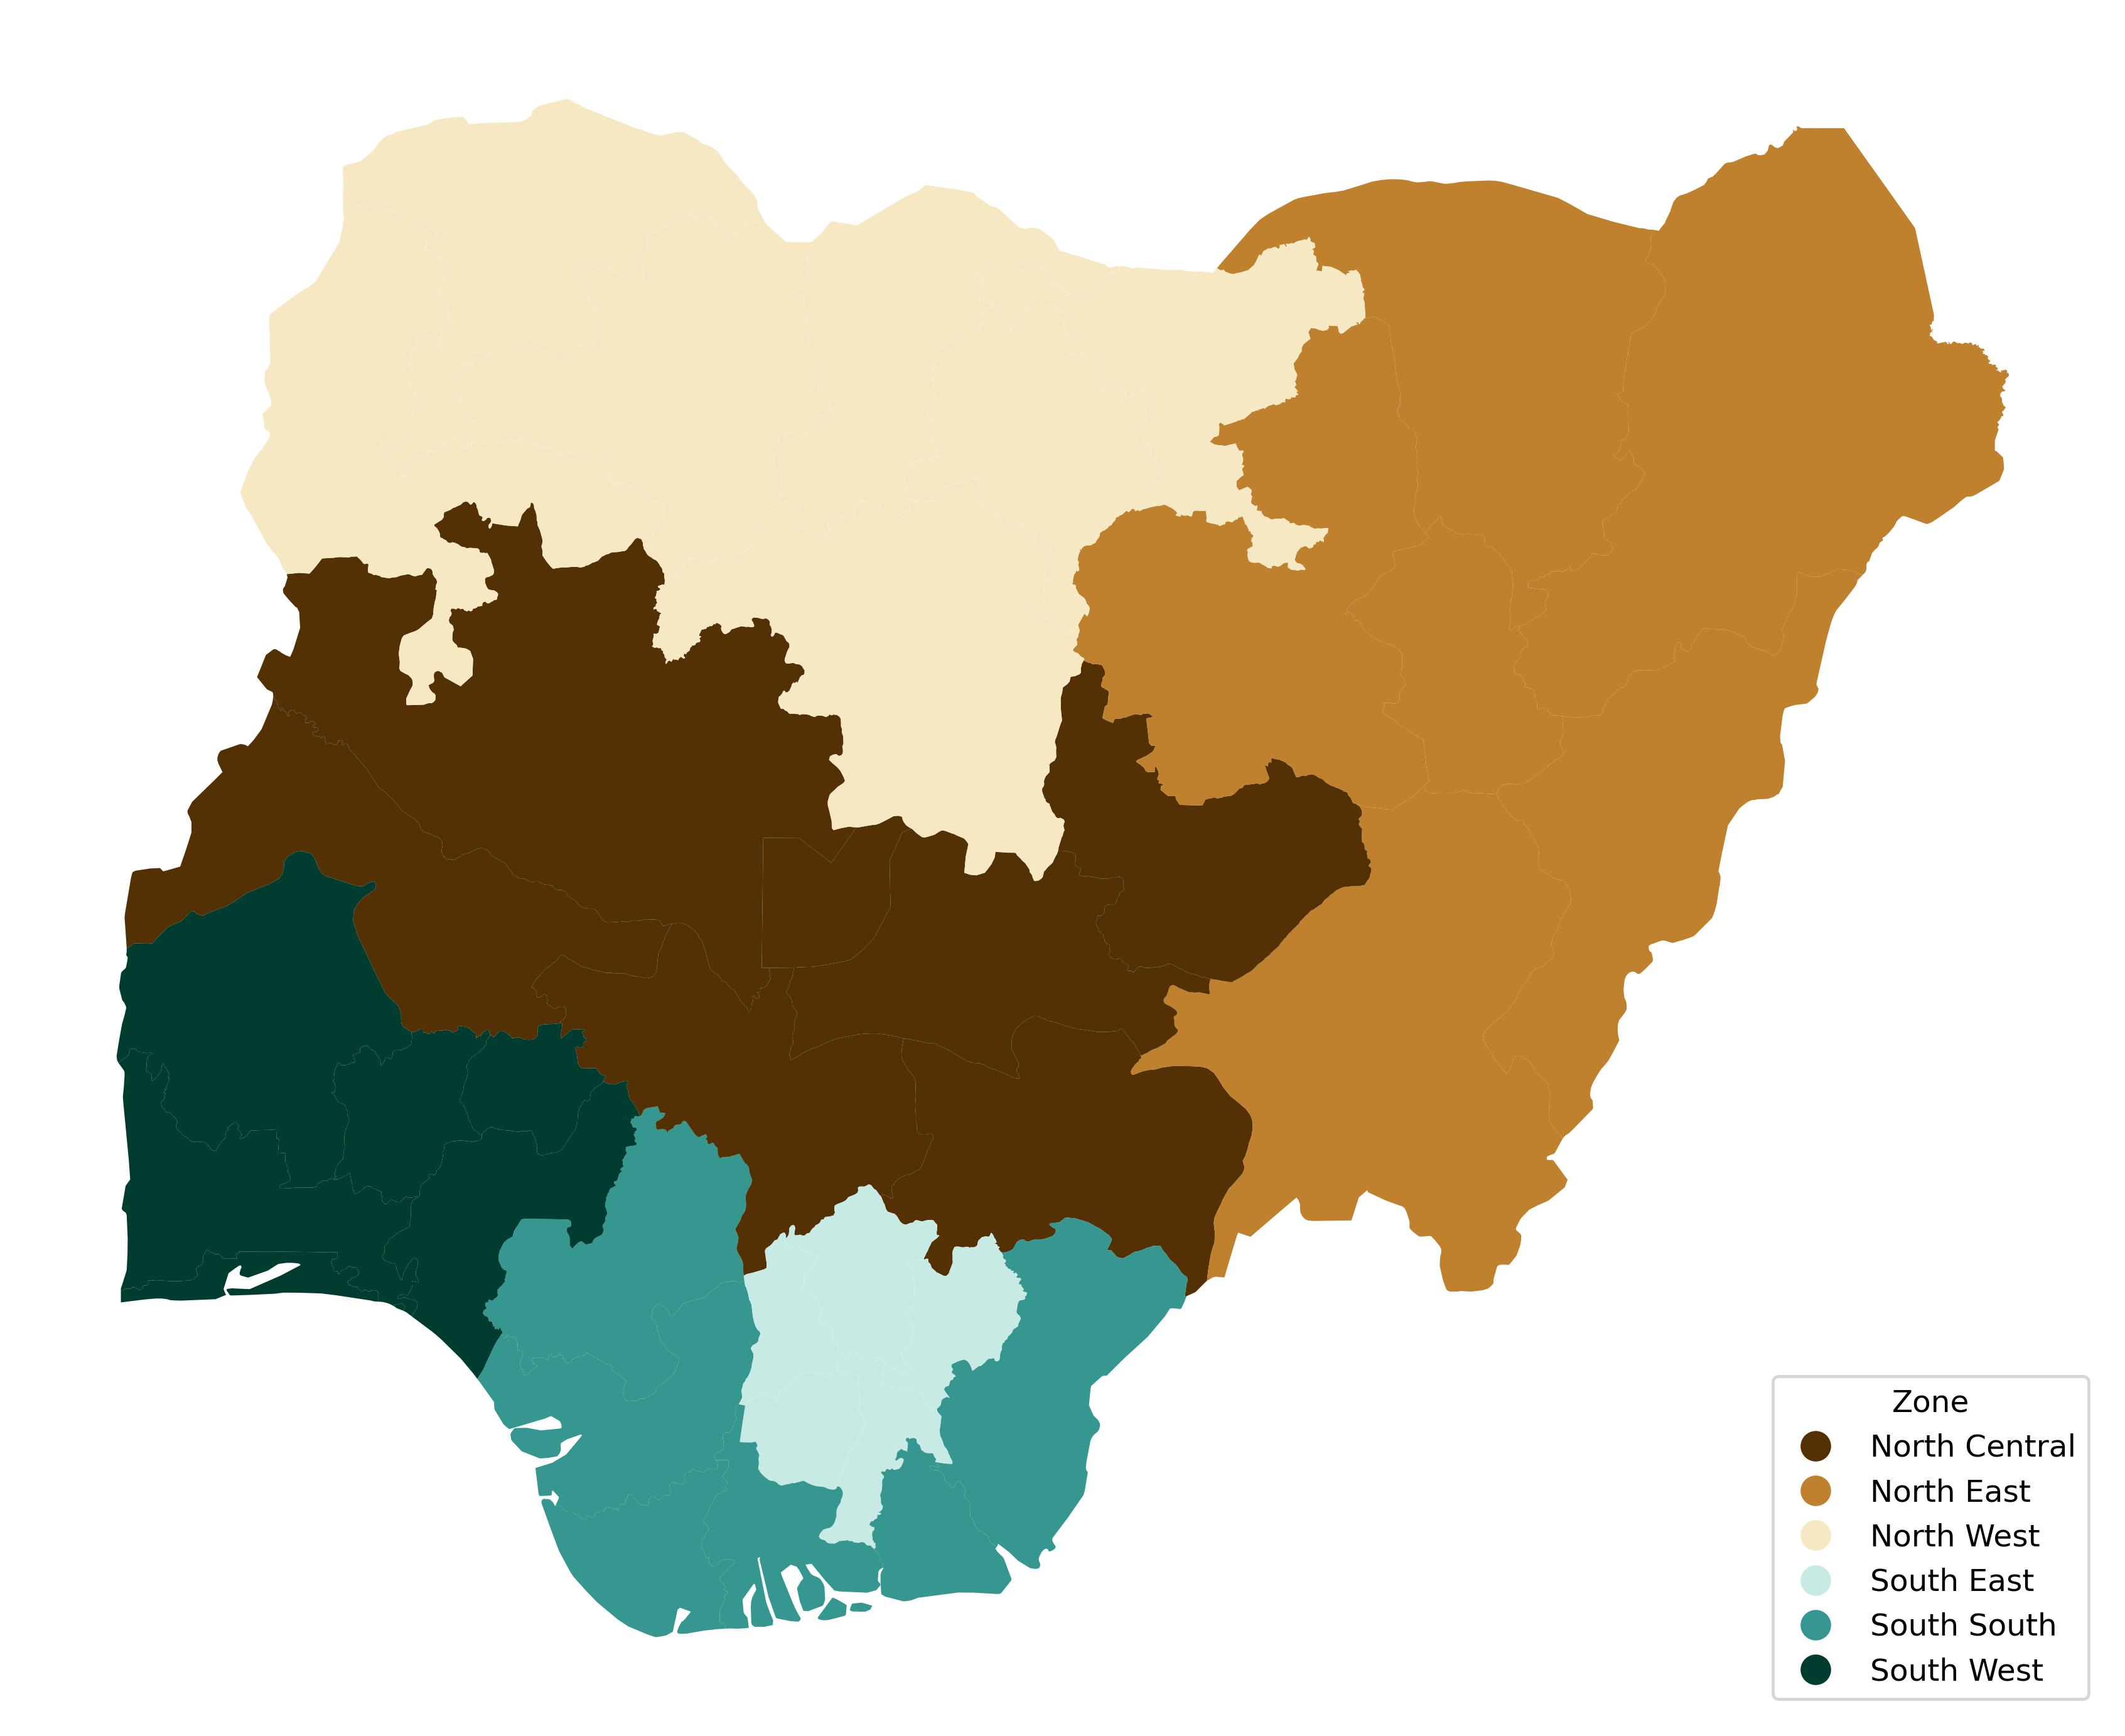

In [155]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 350
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column="zone", 
              ax=ax,
              cmap="BrBG", 
              legend=True, 
              legend_kwds={"title": "Zone", "loc":'lower right'},
        )

ax.set_axis_off()
plt.savefig('map_of_nigeria.png', bbox_inches='tight', format="png")



In [87]:
# Merge the shapefile with your data
map_data = gdf.merge(prevalence_by_zone, how="left", on="zone")
map_data = map_data.query("indicator == 'prob_mod_sev'")

# Categorize the `prob_value` into binary variables
map_data["prob_value"] = map_data["proportion"].apply(lambda x: '60-70%' if 60 <= x <= 70 else ('70-100%' if 70 < x <= 100 else x))


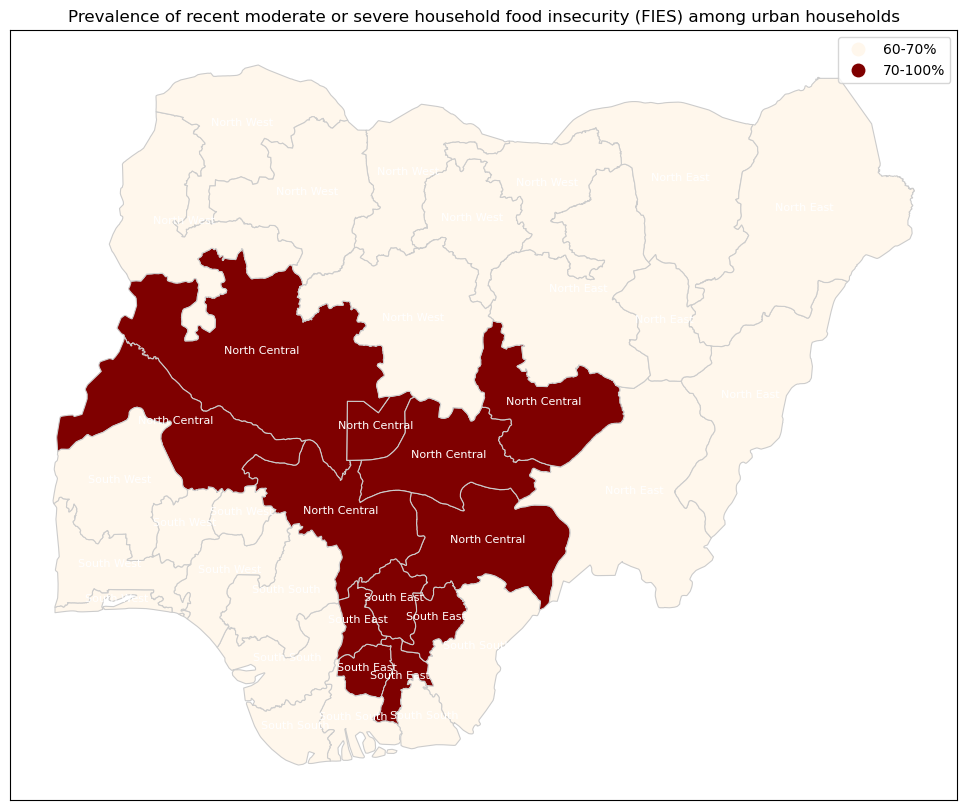

In [88]:
# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
map_data.plot(column="prob_value", cmap="OrRd", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)



# Annotate each state with its name
for idx, row in map_data.iterrows():
    ax.annotate(text=row["zone"], 
                xy=(row.geometry.centroid.x, row.geometry.centroid.y), 
                color="white", fontsize=8, ha="center")


plt.title("Prevalence of recent moderate or severe household food insecurity (FIES) among urban households")

plt.xticks([], [])
plt.yticks([], [])

plt.show()


* Moderate Food Insecurity (prob_mod_sev): The proportions across zones range from around 64% (South West) to 75% (South East), indicating a substantial level of moderate food insecurity in all regions, with the South East and North Centralhaving the highest proportion.

### 2. **FIES Variables Based on Rawscore (Discrete Assignment) Approach**

It is possible to classify respondents based solely on their `raw score`, an approach known as **discrete
assignment**. As it is both easier to implement and explain to different audiences, many countries
with experience-based food security scales have used this approach.

> **How does discrete assignment work?**

>All cases with the same raw score are simply counted to determine the proportion of cases
that fall into a particular food security class. For example, all respondents with raw score 4
or higher may be classified as "moderately or severely food insecure", while all those with
raw scores 7 or 8 may be classified as "severely food insecure". The estimated prevalence
of moderate and severe food insecurity is equal to the ratio between the weighted number
of cases thus classified and the total weighted number of cases.

For Classification Model Purpose, participants can be categorized into three levels of FI based on their scores. [Sheikomar OB, Dean W, Ghattas H, Sahyoun NR. Validity of the FI Experience Scale (FIES) for Use in League of Arab States (LAS) and Characteristics of Food Insecure Individuals by the Human Develop- ment Index (HDI). Curr Dev Nutr. 2021; 5(4):nzab017](https://pubmed.ncbi.nlm.nih.gov/30191202/). 
* 0 to 3 indicate **food secure**, 
* scores ranging from 4 to 6 indicate **moderate FI**, and 
* scores ranging from 7 to 8 indicate **severe FI**

Additionally, **[FAO](https://www.fao.org/3/bp091e/bp091e.pdf) suggested the following thresholds for Binary Classification:**
* Raw score 1 or greater versus raw score 0 ( Value of 1 for those households experiencing one or more form of food insecurity and 0 otherwise, based on the raw FIES score.)
* Raw score 4 or greater versus raw score 0-3 (On average, this corresponds
  approximately to moderately-or-severely food insecure versus secure-or-only-mildly insecure.)
* Raw score 7 or 8 versus raw score 0-6 (On average, this corresponds approximately to severely food insecure versus all others.)


In [89]:
df2 = df2.assign(
    FI_Food_Insecure = np.where(df2["fies_score"] >= 1, 1, 0),
    MSI = np.where(df2["fies_score"] >= 4, 1, 0), # moderate_or_severe
    FS = np.where(df2["fies_score"] < 1, 1, 0),
    SFI = np.where(df2["fies_score"] >= 7, 1, 0),
    fies_0_3_7 = pd.cut(df2["fies_score"], bins=[0,4,7, float("inf")], labels=["0-3", "4-6", "7-8"], right=False),
)


**Impact**

Based on these approaches, we end up with four sets of food insecurity indicators: 

* raw responses to each of the eight questions
* `FI_Food_Insecure`: Raw score 1 or greater versus raw score 0 (any indication of food insecurity)
* `fies_score`: raw score across the eight questions
* `FS`: Binary indicator of experience of food insecurity (assuming a value of 1 for those households with raw score is equal to zero and 0 otherwise)
* `MSI`: Binary indicator of food insecure  (assuming a value of 1 for those household with raw score 4 or greater and 0 otherwise) 
*  `SFI`: Binary indicator of Food insecure  (assuming a value of 1 for those household with raw score 7-8 and 0 otherwise)
*  `fies_0_3_7`: Multpiple indicator of FIES assuming raw score
      - 0 to 3 ==> indicate food secure,
      - 4 to 6 ==> indicate moderate FI,
      - 7 to 8 ==> severe FI



In [97]:
# Merge the shapefile with your data
gdf.merge(df2, how="left", on="zone")[["state","zone", "geometry", "MSI", "FS", "SFI", "FI_Food_Insecure"]]

In [90]:
df2.head()

,hh1,hh2,area,zone,hh_members_num,num_of_women_15_49,num_of_men_15_49,num_under_5_child,num_5_17_child,hhsex,hhage,helevel,hh_own_dwelling,hh_agricultural_land,hh_own_animal,hh_mn_attended_sch_num,hh_mn_mean_age_yrs,hh_mn_attended_atleast_sec_sch,hh_mn_mean_life_satisfaction,hh_wm_attended_sch_num,hh_wm_mean_age_yrs,hh_wm_attended_atleast_sec_sch,hh_wm_mean_life_satisfaction,water_source,wi_quintile_mics,wscoremics,urban_wi_quintile_mics,hh_ls_num,fies_score,hhweightmics,psu,stratum,prob_mod_sev,prob_sev,rs_fies_score,WORRIED,HEALTHY,FEWFOOD,SKIPPED,ATELESS,RANOUT,HUNGRY,WHLDAY,hh_ag_land_size_cat,agg_wealth_index,cluster_wi_category,hh_ls_num_clean_iqr,hh_ls_num_clean,hh_members_num_clean_iqr,hh_members_num_clean,num_adult,num_children,hh_siz_cat,hh_age_cat,hh_num_child_cat,hh_num_adult_cat,PFI_moderate_severe,PFI_severe,PFI_mid_moderate,FI_Food_Insecure,MSI,FS,SFI,fies_0_3_7
0,1.0,1.0,URBAN,South East,4.0,3.0,0.0,0.0,1.0,Female,46.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,3.0,28.666667,2.0,3.333333,TUBE WELL / BOREHOLE,Fourth,0.839976,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare,1.002562,High,0.0,0.000000,4.0,1.43299,3.0,1.0,<5,>45,<2,>1,1,0,0,1,1,0,1,7-8
1,1.0,2.0,URBAN,South East,2.0,2.0,0.0,0.0,1.0,Female,45.0,Senior secondary,RENT,NO,NO,0.0,0.0,0.0,0.0,2.0,30.500000,2.0,5.500000,TUBE WELL / BOREHOLE,Fourth,0.695187,Second,0,6,0.61955,1.0,1.0,0.971,0.043,6,1,1,1,1,1,1,0,0,0 hectare,1.002562,High,0.0,0.000000,2.0,2.00000,2.0,1.0,<5,36-45,<2,>1,1,0,0,1,1,0,0,4-6
2,1.0,3.0,URBAN,South East,5.0,1.0,0.0,2.0,1.0,Male,41.0,Senior secondary,OWN,NO,YES,0.0,0.0,0.0,0.0,1.0,34.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,1.031051,Middle,30,5,0.61955,1.0,1.0,0.875,0.002,5,1,0,0,1,1,1,1,0,0 hectare,1.002562,High,0.0,0.074929,5.0,1.43299,1.0,3.0,<5,36-45,>1,<2,1,0,0,1,1,0,0,4-6
3,1.0,4.0,URBAN,South East,4.0,1.0,1.0,0.0,0.0,Male,81.0,No Education,OWN,YES,YES,1.0,33.0,1.0,5.0,1.0,38.000000,1.0,8.000000,TUBE WELL / BOREHOLE,Middle,-0.190450,Poorest,144,7,0.61955,1.0,1.0,0.995,0.390,7,0,1,1,1,1,1,1,1,1-9 hectares,1.002562,High,0.0,0.074929,4.0,1.43299,2.0,0.0,<5,>45,<2,>1,1,0,0,1,1,0,1,7-8
4,1.0,5.0,URBAN,South East,5.0,1.0,0.0,0.0,1.0,Male,63.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,1.0,23.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,0.999549,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare,1.002562,High,0.0,0.000000,5.0,1.43299,1.0,1.0,<5,>45,<2,<2,1,0,0,1,1,0,1,7-8


### **Weighted Affirmative Response FIES Items**

**Food insecurity metric based on responses provided to each of the FIES questions**


We already performed the weighted affirmative response of the food insecurity experience scale items in this notebook. [Affirmative Items](notebooks/2_rasch_model_urban.ipynb) 

In [73]:
fies_item_perc =  pd.read_csv("../processed_data/fies_item_parameter_statistics_urban.csv", index_col=0)

fies_item_perc.loc[:, ["Item", "Weighted.perc..of.Yes", "Unweighted.perc..of.Yes"]]

,Item,Weighted.perc..of.Yes,Unweighted.perc..of.Yes
1,WORRIED,0.76,0.76
2,HEALTHY,0.72,0.72
3,FEWFOOD,0.72,0.72
4,SKIPPED,0.65,0.64
5,ATELESS,0.69,0.69
6,RANOUT,0.57,0.57
7,HUNGRY,0.48,0.50
8,WHLDAY,0.26,0.29


##### Overall FIES Items Response

In [74]:
fies_questions = df2.loc[:, list(df2.loc[:, "WORRIED":"WHLDAY"].columns) + ["hhweightmics"]]

# Turn from wide to long data format
fies_long = pd.melt(fies_questions, id_vars=['hhweightmics'], var_name='Question', value_name='Response',)

cross_tab_prop = pd.crosstab(index=fies_long['Question'],
                             columns=fies_long['Response'],
                             normalize="index")

cross_tab_prop = cross_tab_prop.sort_values(by=1, ascending=False)
cross_tab= pd.crosstab(index=fies_long["Question"], columns=fies_long["Response"]).sort_values(by=1, ascending=False)
cross_tab_prop.columns = ["No", "Yes"]

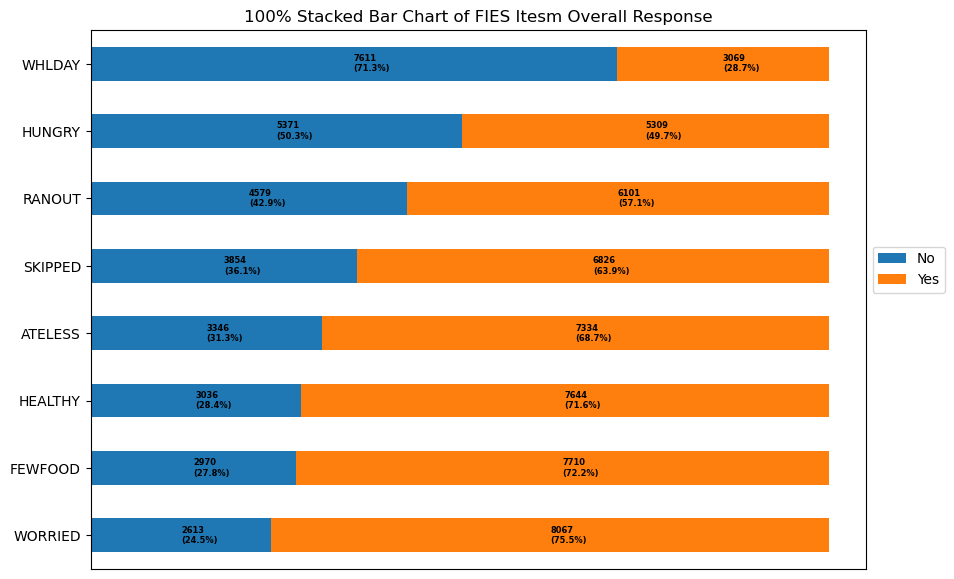

In [75]:

eda_utils.plot_fies_item_stacked_bar(cross_tab_prop, 
                                     cross_tab,
                                    title="100% Stacked Bar Chart of FIES Itesm Overall Response")


**Observation**

When looking at the distribution of affirmative answers to each FIES question we observe the following:

* The item `WHLDAY` has the lowest affirmative response (29%). This item has the highest severity, implies, of all the items, therefore, expected to received the fewest number of "YES" response.
* The item `WORRIED` have the highest affirmative response (76%). This make sense considering it the FIES item with the lowest severity according to the Rasch model result. Therefore, it expected that more responsdent will give an affirmative response.


##### Analysis of FIES Item by Zone
Number of affirmative response. ie. Yes responses

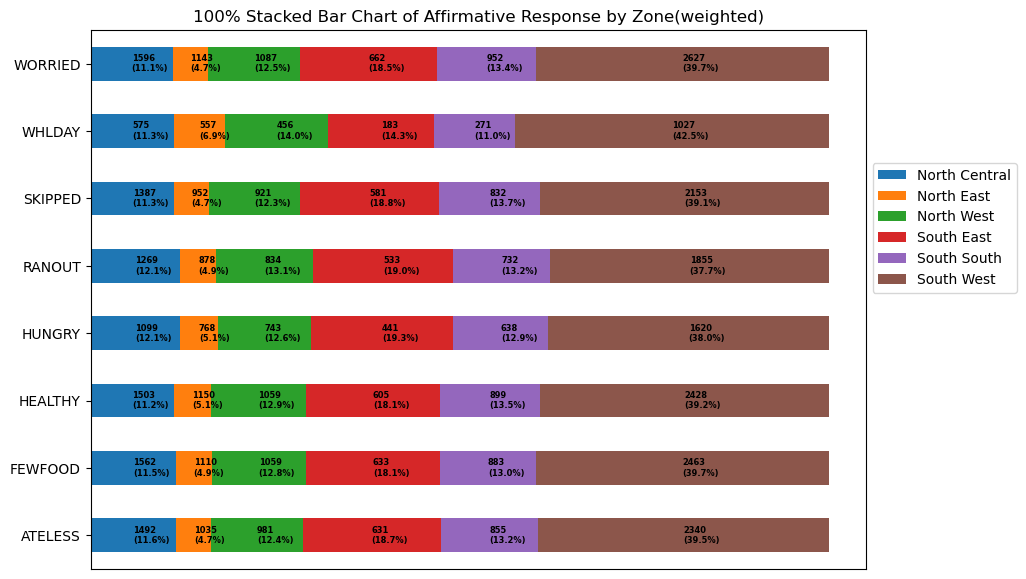

In [76]:
# Weighted relevance of each question (number of positive answers) in the different zones
fies_zone_prop, fies_zone_ = eda_utils.process_fies_question_data_wt(df2, col="zone")

# PLot the outcome
eda_utils.plot_fies_item_stacked_bar(fies_zone_prop, fies_zone_, title="100% Stacked Bar Chart of Affirmative Response by Zone(weighted)")

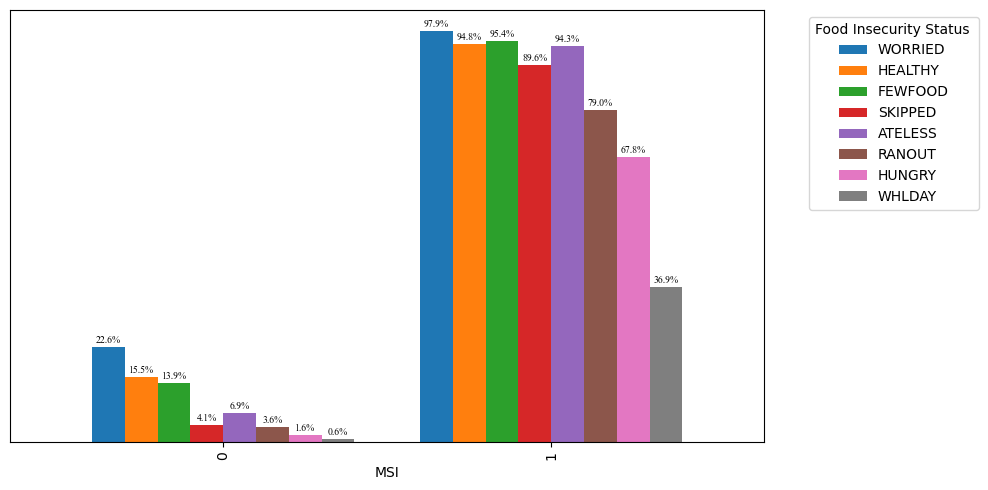

,WORRIED,HEALTHY,FEWFOOD,SKIPPED,ATELESS,RANOUT,HUNGRY,WHLDAY
MSI,,,,,,,,
0,22.647078,15.462245,13.901638,4.094636,6.948871,3.597142,1.590703,0.635438
1,97.863621,94.775378,95.407388,89.596967,94.293709,79.020180,67.773070,36.896383


In [77]:
subset = df2.loc[:, "WORRIED": "WHLDAY"].columns.to_list()


def fies_quest_grp_col(df:pd.DataFrame, grp_col:str, subset:list, wt:str="hhweightmics")->pd.DataFrame:

    df = df.dropna(subset=subset)
    
    weighted_subset = (
        df[subset].astype(float).multiply(df[wt], axis=0)
    )
    weighted_df = df[[grp_col, wt]].join(weighted_subset)

    # Group by state and sum the weighted counts and weights
    grouped = weighted_df.groupby(grp_col, observed=True).sum()

    # Calculate the percentage for each shock
    for col in subset:
        grouped[col] = (grouped[col] / grouped[wt]) * 100
        # Keep only the percentage columns
    percentage_columns = [col for col in subset]
    all_shocks_by_state = grouped[percentage_columns]
    return all_shocks_by_state


rs = fies_quest_grp_col(df2, "MSI", subset)

eda_utils.plot_grouped_data(rs, kind="bar",figsize=(10, 5),title="", legend_title="Food Insecurity Status ")

rs

* Fewer respondents who not Moderate or severely food insecure reported extreme outcomes like going a whole day without eating (WHLDAY), with 0.6% reporting this issue compared to responsed who experence MSI at 36%.

##### Analysis of FIES Items by Severe Level of Food insecurity

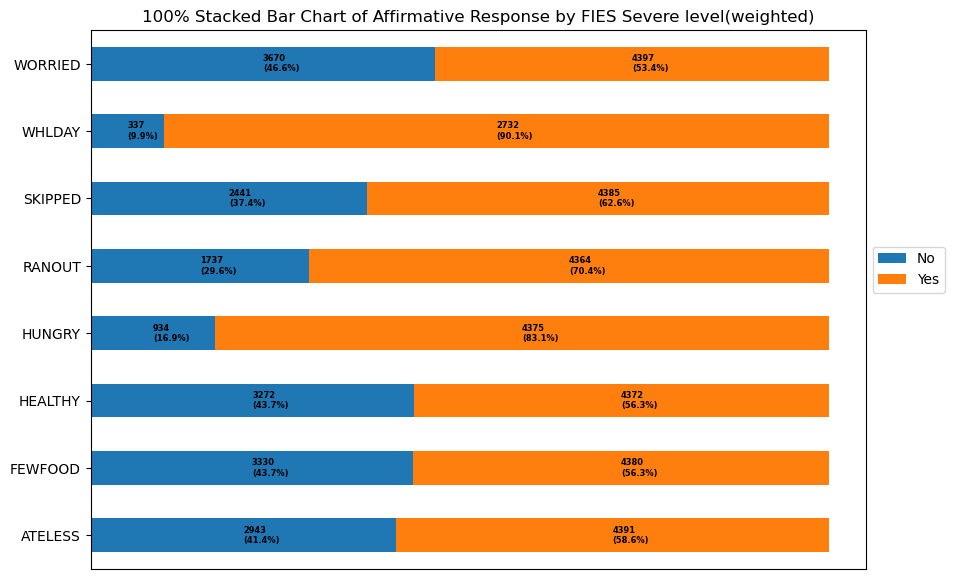

In [78]:
# Weighted relevance of each question (number of positive answers) in the different zones
FI_sev_prop, FI_sev_count = eda_utils.process_fies_question_data_wt(df2, col="SFI")
FI_sev_prop.columns = ["No", "Yes"]

# PLot the outcome
eda_utils.plot_fies_item_stacked_bar(FI_sev_prop, FI_sev_count, 
                                     title="100% Stacked Bar Chart of Affirmative Response by FIES Severe level(weighted)")


* `WHLDAY`(97.50%), have the highest percentages of "Yes" responses, highlighting severe levels of food insecurity.
* `WORRIED` (15.4%) has a highest but still substantial small "No" response rate. This make sense considering it the FIES item with the lowwest severity according to the Rasch model result.

## Prevalence of Moderate and/or Severe Food Insecurity among household with Discrete Approach

1. Prevalence of moderate and/or severe food insecurity among urban hh, by zone.
2. Prevalence of moderate severe food insecurity among urban hh, by zone and household wealth index.
3. Prevalence of severe food insecurity among urban hh, by zone and household wealth index.
4. Prevalence of moderate and/or severe food insecurity among urban hh, by zone and household head gender
5. Prevalence of food insecurity among urban household, by zone and hh_agricultural_land
6. Prevalence of food insecurity among urban household, by zone and hh_ag_land_size_cat if hh_agricultural_land is Yes
7. Prevalence of food insecurity among urban household, by zone and hh_own_animal
8. Prevalence of moderate or severe food insecurity by zone by hh_own_dwelling



### 1. Prevalence of moderate and/or severe food insecurity among urban hh, by zone.(Weighted)

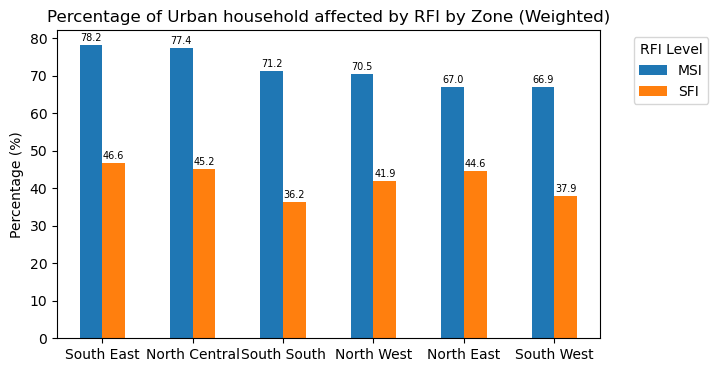

In [79]:
fies_by_zone = eda_utils.fies_by_socio_demo(df2, "zone", FI_mod_sev="MSI", FI_sev="SFI", wt="hhweightmics")
grp_zone_by_fies = fies_by_zone.groupby(["zone", "RFI_level"], observed=True)["percentage"].sum().unstack()

# Plot prevalance of FI by zone
eda_utils.plot_fies_levels_by_vars(grp_zone_by_fies,var="zone", sortby_col="MSI",
                                   title="Percentage of Urban household affected by RFI by Zone (Weighted)")

In [80]:
# Check if the differences is significant
print("\n==========Is the difference significant +==========")
eda_utils.chi_square_test(df2, "zone",fi_var1="SFI", fi_var2='MSI')


==========Is the difference significant +==========


{'P-value SFI': 1.0110267959678246e-05, 'P-value MSI': 1.9190629991386265e-12}

* South East presents the highest percentage(78.3%) of urban households affected by RFI at Severe level.
* South West presents the lowest percentage of urban household affected by RFI at moderate or severe level(MSI) (66.9 percent)
* The p-value shows this difference is statistically significant


### 2. Prevalence of moderate or severe food insecurity among urban hh, by zone and household wealth index.

Examining heterogeneity across urban household wealth index. 

Hypothesis: poorer households (in lower quintiles) suffer significantly greater prevalence of food insecurity

In [81]:
import pandas as pd

def proportion_of_fi_by_grp_col(df, fi_indicator="MSI", zone_col="zone", grp_col="hhsex", wt="hhweightmics"):
    """
    Calculate the proportion of gender within each zone based on a binary response.

    Parameters:
    df (pd.DataFrame): The input dataframe containing the data.
    fi_indicator (str): The name of the column with binary responses (e.g., 'MSI').
    zone_col (str): The name of the column representing the zone or country (e.g., 'zone').
    gender_col (str): The name of the column representing gender (e.g., 'hhsex').

    Returns:
    pd.DataFrame: A dataframe with the calculated proportions.
    """
    # Filter rows with positive response
    df_positive = df[df[fi_indicator] == 1]
    
    # Calculate total weighted responses per country
    total_weighted_by_zone = df_positive.groupby(zone_col, observed=True)[wt].sum().reset_index()
    total_weighted_by_zone.columns = [zone_col, 'total_weighted']
    
    # Calculate weighted responses by gender and country
    weighted_by_grp_col_zone = df_positive.groupby([zone_col, grp_col], observed=True)[wt].sum().reset_index()
    
    # Merge with total weights to calculate percentage
    result = pd.merge(weighted_by_grp_col_zone, total_weighted_by_zone, on=zone_col)
    result['weighted_percentage'] = (result[wt] / result['total_weighted']) * 100

    prevalance_df = result[[zone_col, grp_col, 'weighted_percentage']]
    return prevalance_df

prevalence_by_zone_by_wi = proportion_of_fi_by_grp_col(df2, fi_indicator="MSI", 
                                                       zone_col="zone",
                                                       grp_col="urban_wi_quintile_mics"
                                                      )


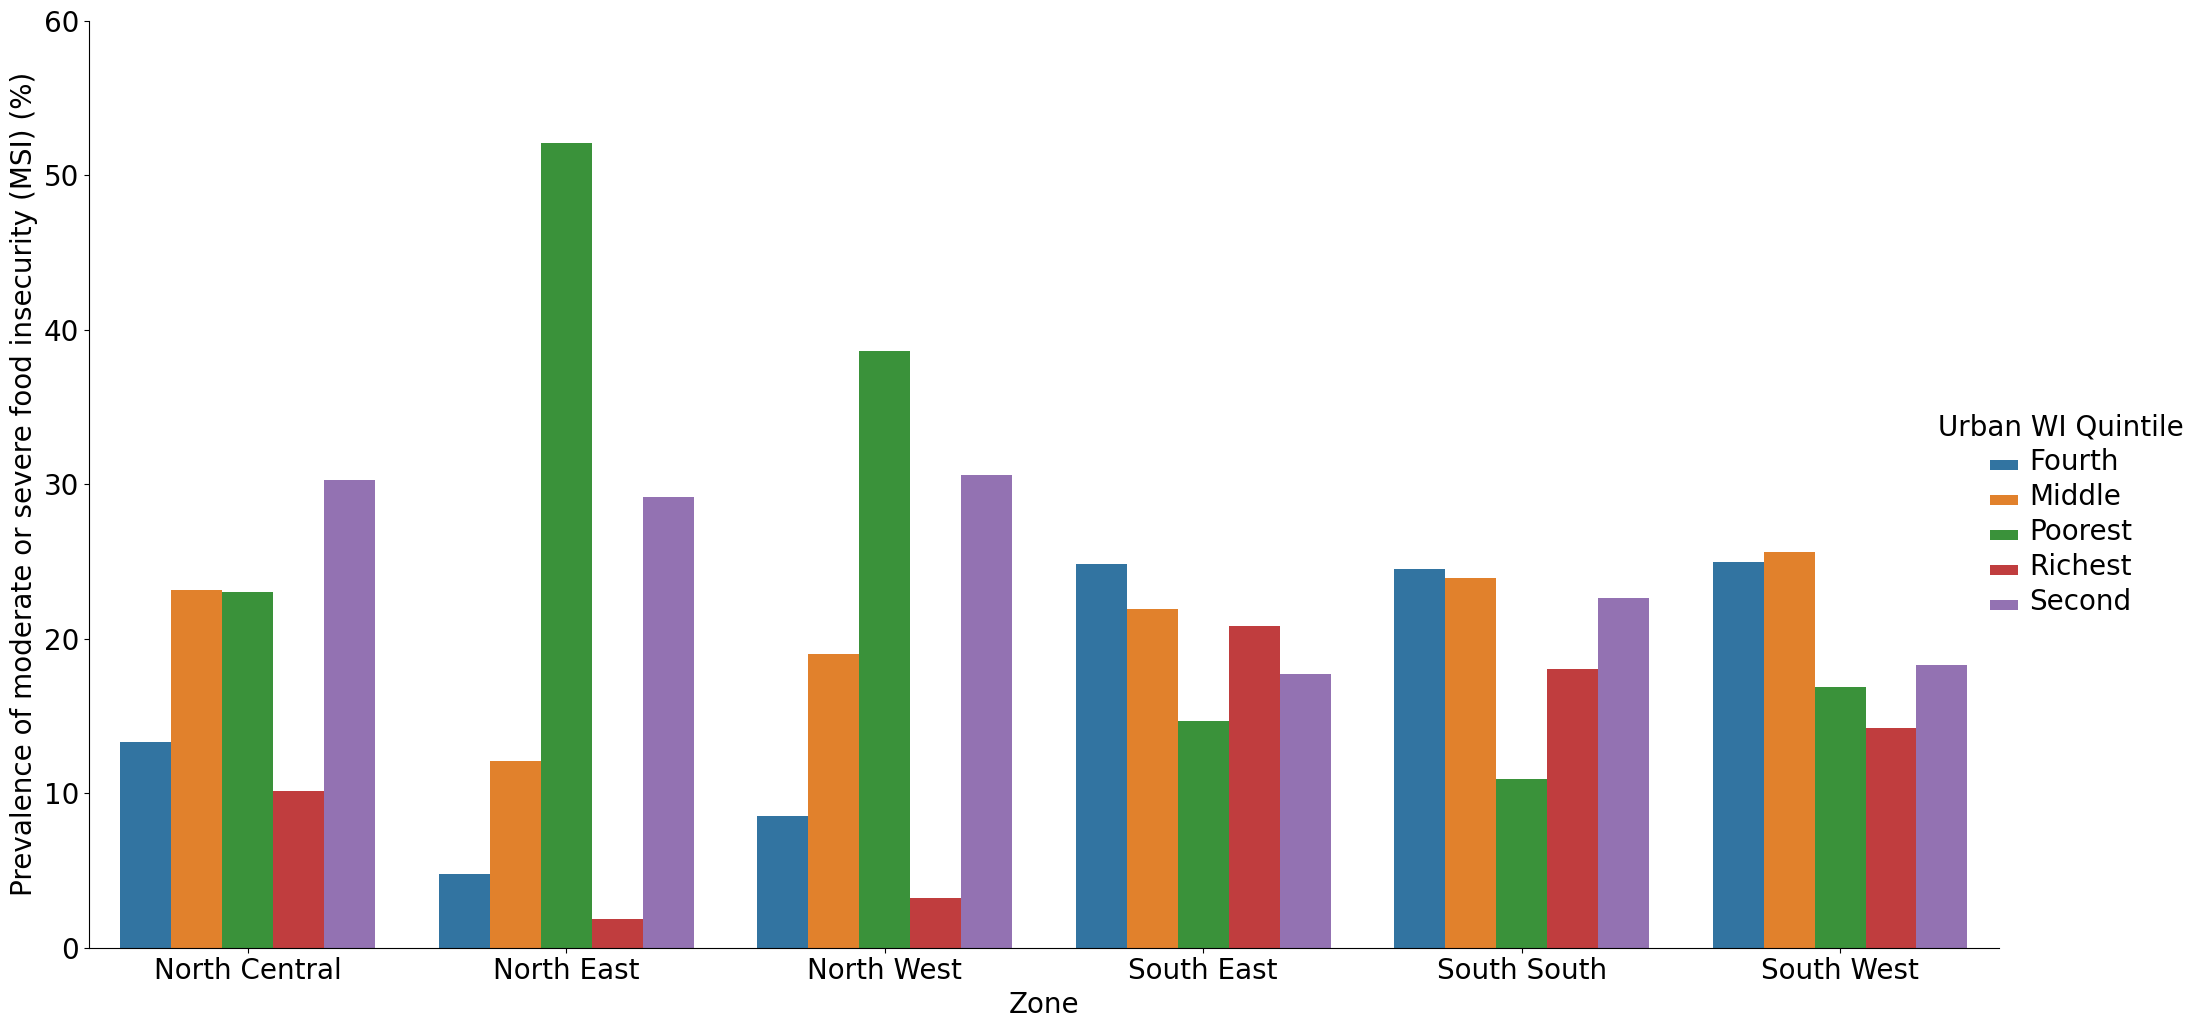

In [82]:
a = sns.catplot(x="zone", y="weighted_percentage",
            hue="urban_wi_quintile_mics",
            data=prevalence_by_zone_by_wi, kind="bar",
            height=10,
            estimator="mean", 
            aspect=2);

# Add y-label
a.set_axis_labels("Zone", "Prevalence of moderate or severe food insecurity (MSI) (%)", fontsize=20)
# Set axis labels with increased font size

# Increase the font size of the tick labels
a.set_xticklabels(fontsize=20)
a.set_yticklabels(fontsize=20)

# Adjust the legend font size
a.legend.set_title("Urban WI Quintile", prop={'size': 20})
for text in a.legend.texts:
    text.set_fontsize(20)

### 3. Prevalence of severe food insecurity among urban hh, by zone and household wealth index.
Examining heterogeneity across urban household wealth index. 

Hypothesis: richer households (in higher quintiles) suffer significantly lesser prevalence of food insecurity

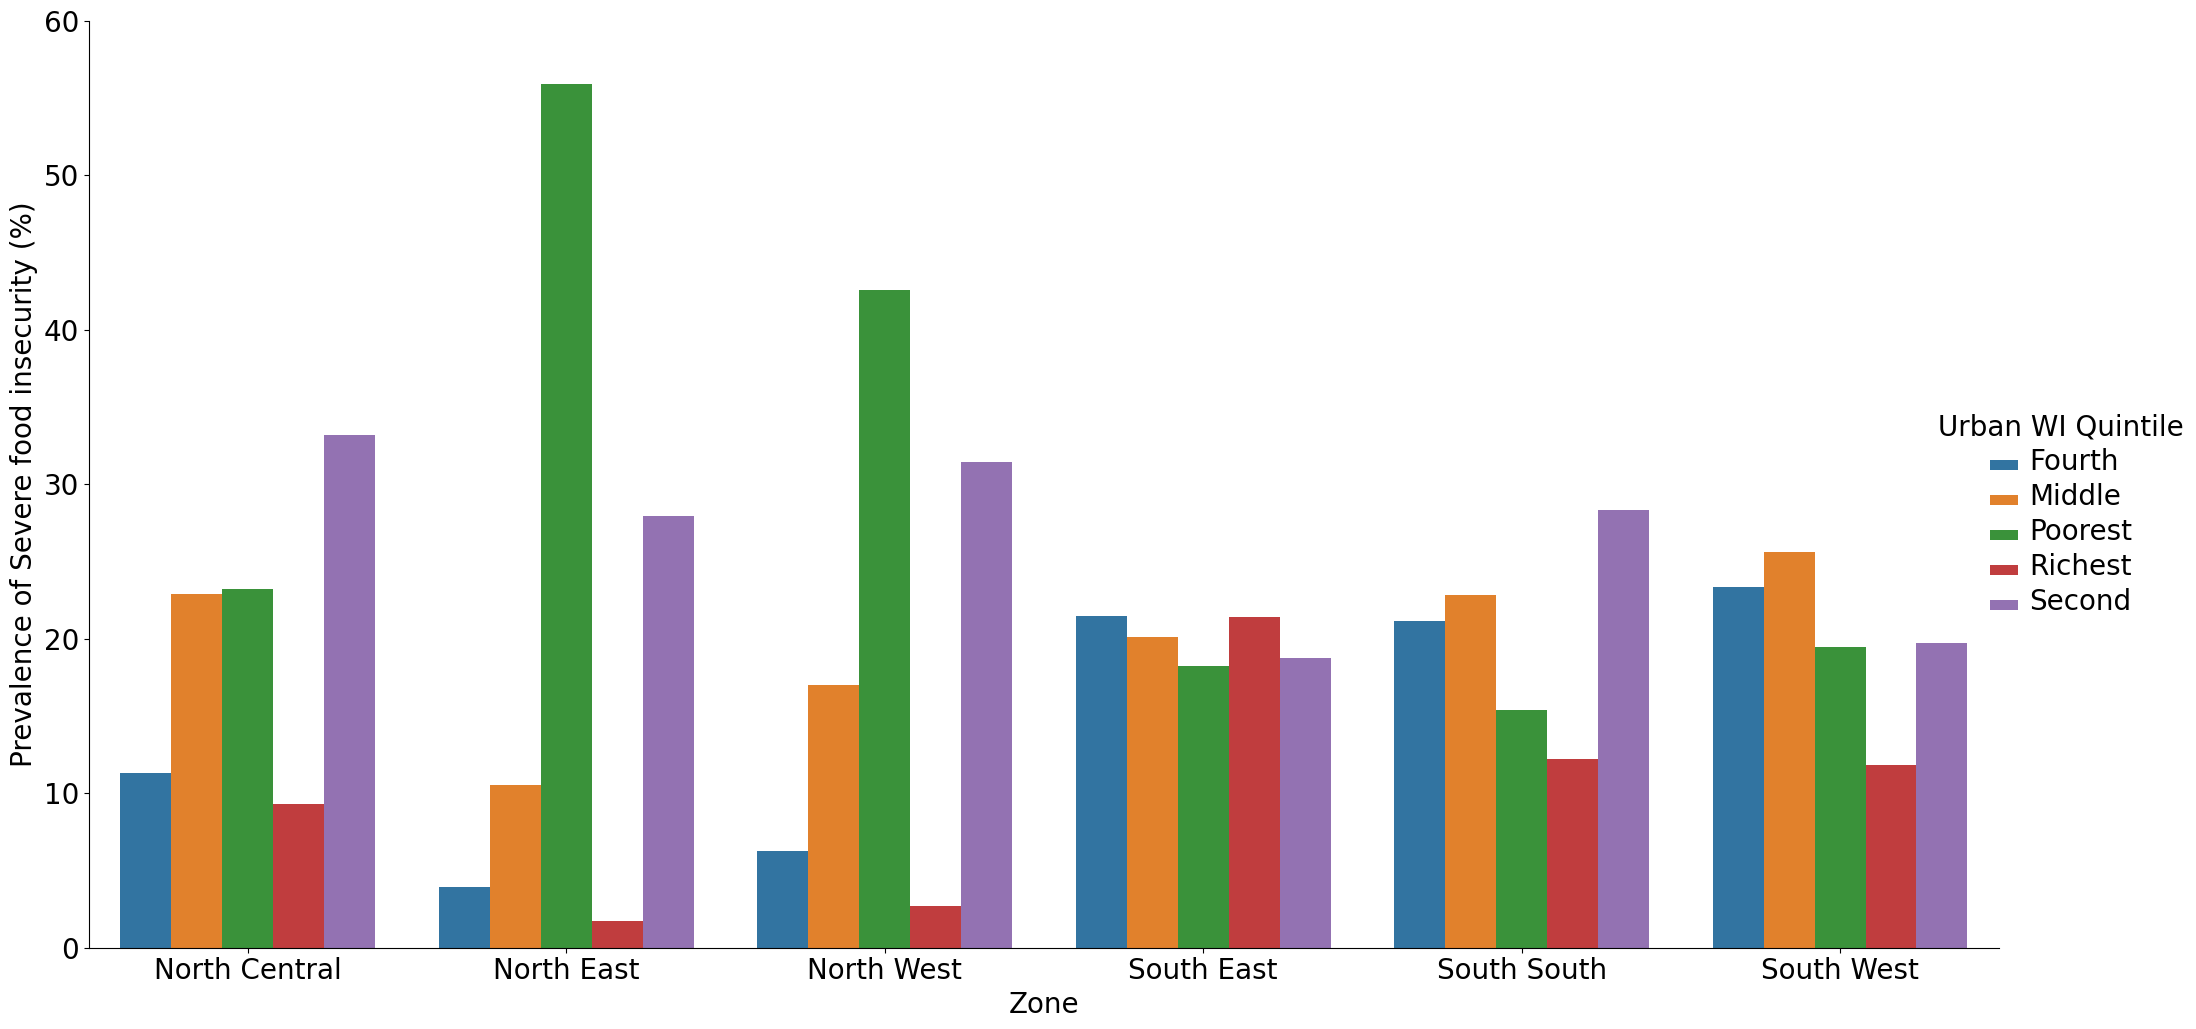

In [83]:
prevalence_sfi_zone_wealth_index = proportion_of_fi_by_grp_col(df2, 
                                                               fi_indicator="SFI", 
                                                               zone_col="zone", 
                                                               grp_col="urban_wi_quintile_mics")



g = sns.catplot(x="zone", y="weighted_percentage",
            hue="urban_wi_quintile_mics",
            data=prevalence_sfi_zone_wealth_index, kind="bar",
            height=10,
            # errorbar="se",
            estimator="mean", 
            aspect=2);

# Add y-label
g.set_axis_labels("Zone", "Prevalence of Severe food insecurity (%)", fontsize=20)
# Set axis labels with increased font size

# Increase the font size of the tick labels
g.set_xticklabels(fontsize=20)
g.set_yticklabels(fontsize=20)

# Adjust the legend font size
g.legend.set_title("Urban WI Quintile", prop={'size': 20})
for text in g.legend.texts:
    text.set_fontsize(20)

#### Weighted Prevalance of moderate and/or severe food insecurity by urban household wealth index

{'P-value SFI': 5.3926001284033214e-114, 'P-value MSI': 2.0960127990861645e-172}


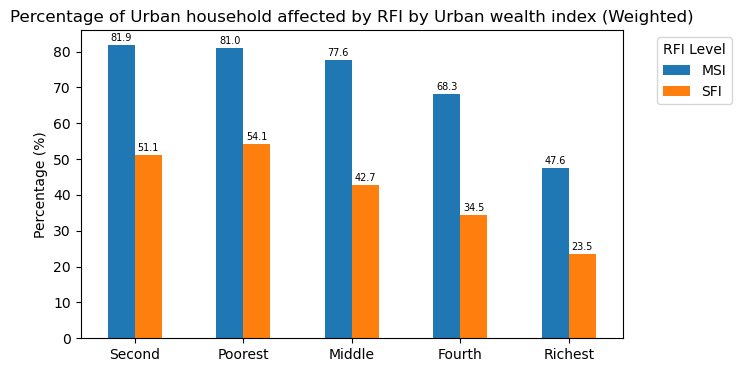

In [84]:
fies_by_wi = eda_utils.fies_by_socio_demo(df2, "urban_wi_quintile_mics", FI_mod_sev="MSI", FI_sev="SFI", wt="hhweightmics")
grp_wi_by_fies = fies_by_wi.groupby(["urban_wi_quintile_mics", "RFI_level"], observed=True)["percentage"].sum().unstack()


print(eda_utils.chi_square_test(df2, "urban_wi_quintile_mics", fi_var1="SFI", fi_var2='MSI'))

# Plot prevalance of FI by urban household wealth index
eda_utils.plot_fies_levels_by_vars(grp_wi_by_fies, var="urban_wi_quintile_mics", sortby_col="MSI",
                                   title="Percentage of Urban household affected by RFI by Urban wealth index (Weighted)")

### 4. **Prevalence of food insecurit by Household Head Gender**

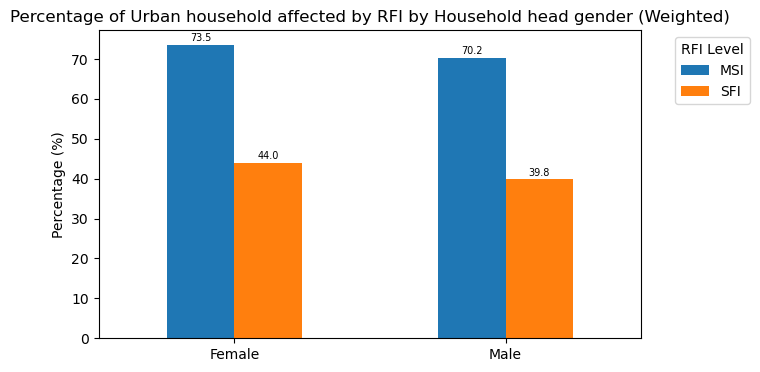

{'P-value SFI': 0.009093369388271122, 'P-value MSI': 0.01229515055030632}

In [85]:
fies_by_hhsex = eda_utils.fies_by_socio_demo(df2, "hhsex", FI_mod_sev="MSI", FI_sev="SFI", wt="hhweightmics")
grp_hhsex_by_fies = fies_by_hhsex.groupby(["hhsex", "RFI_level"], observed=True)["percentage"].sum().unstack()

# Plot prevalance of FI by zone
eda_utils.plot_fies_levels_by_vars(grp_hhsex_by_fies,var="hhsex", sortby_col="MSI",
                                   title="Percentage of Urban household affected by RFI by Household head gender (Weighted)")

eda_utils.chi_square_test(df2, "hhsex", fi_var1="SFI", fi_var2='MSI')


* The level of Food insecurity at moderate or severe level (MSI), and Severe level (SF) were higher for urban female-headed households
* The differenrces are statistically significant.

### 4b. Prevalence of moderate and/or severe food insecurity among urban household by zone and gender of the head of house

In [86]:
def calculate_proportions(df, hh_var="hhsex", fi_cols=None, weight_col="hhweightmics"):
    """
    Calculate the proportion of each food insecurity indicator by zone and gender of the head of the house.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the data.
    - fi_cols (list of str): List of column names for food insecurity indicators.
    - weight_col (str): The column name for the weights.

    Returns:
    - pd.DataFrame: A DataFrame with the proportions of food insecurity indicators by each group.
    """
    fi_cols =["MSI", "SFI"]
    # Melt the DataFrame to long format
    df_melted = df.melt(id_vars=["zone", hh_var, weight_col], 
                        value_vars=fi_cols,
                        var_name="FI", value_name="Response")

    # Calculate the weighted response
    df_melted['weighted_response'] = df_melted['Response'] * df_melted[weight_col]

    # Group by 'zone', 'hhsex', and 'FI'
    grouped = df_melted.groupby(['zone', hh_var, 'FI'], observed=True).agg(
        weighted_sum_response=('weighted_response', 'sum'),
        total_weight=(weight_col, 'sum')
    ).reset_index()

    # Compute the proportion as a percentage
    grouped['proportion'] = (grouped['weighted_sum_response'] / grouped['total_weight']) * 100
    
    return grouped


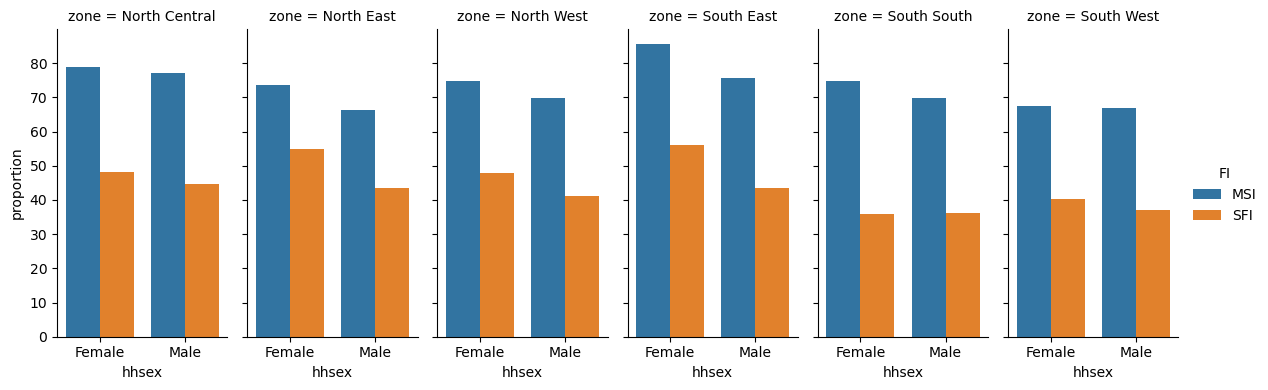

In [87]:
proportions_df = calculate_proportions(df2, hh_var="hhsex")


sns.catplot(x="hhsex", y="proportion",
             hue="FI", col="zone",
             data=proportions_df, kind="bar",
            errorbar="se",estimator="mean",
             height=4, aspect=.5);

### 5. Prevalence of food insecurity among urban household, by zone and hh_agricultural_land

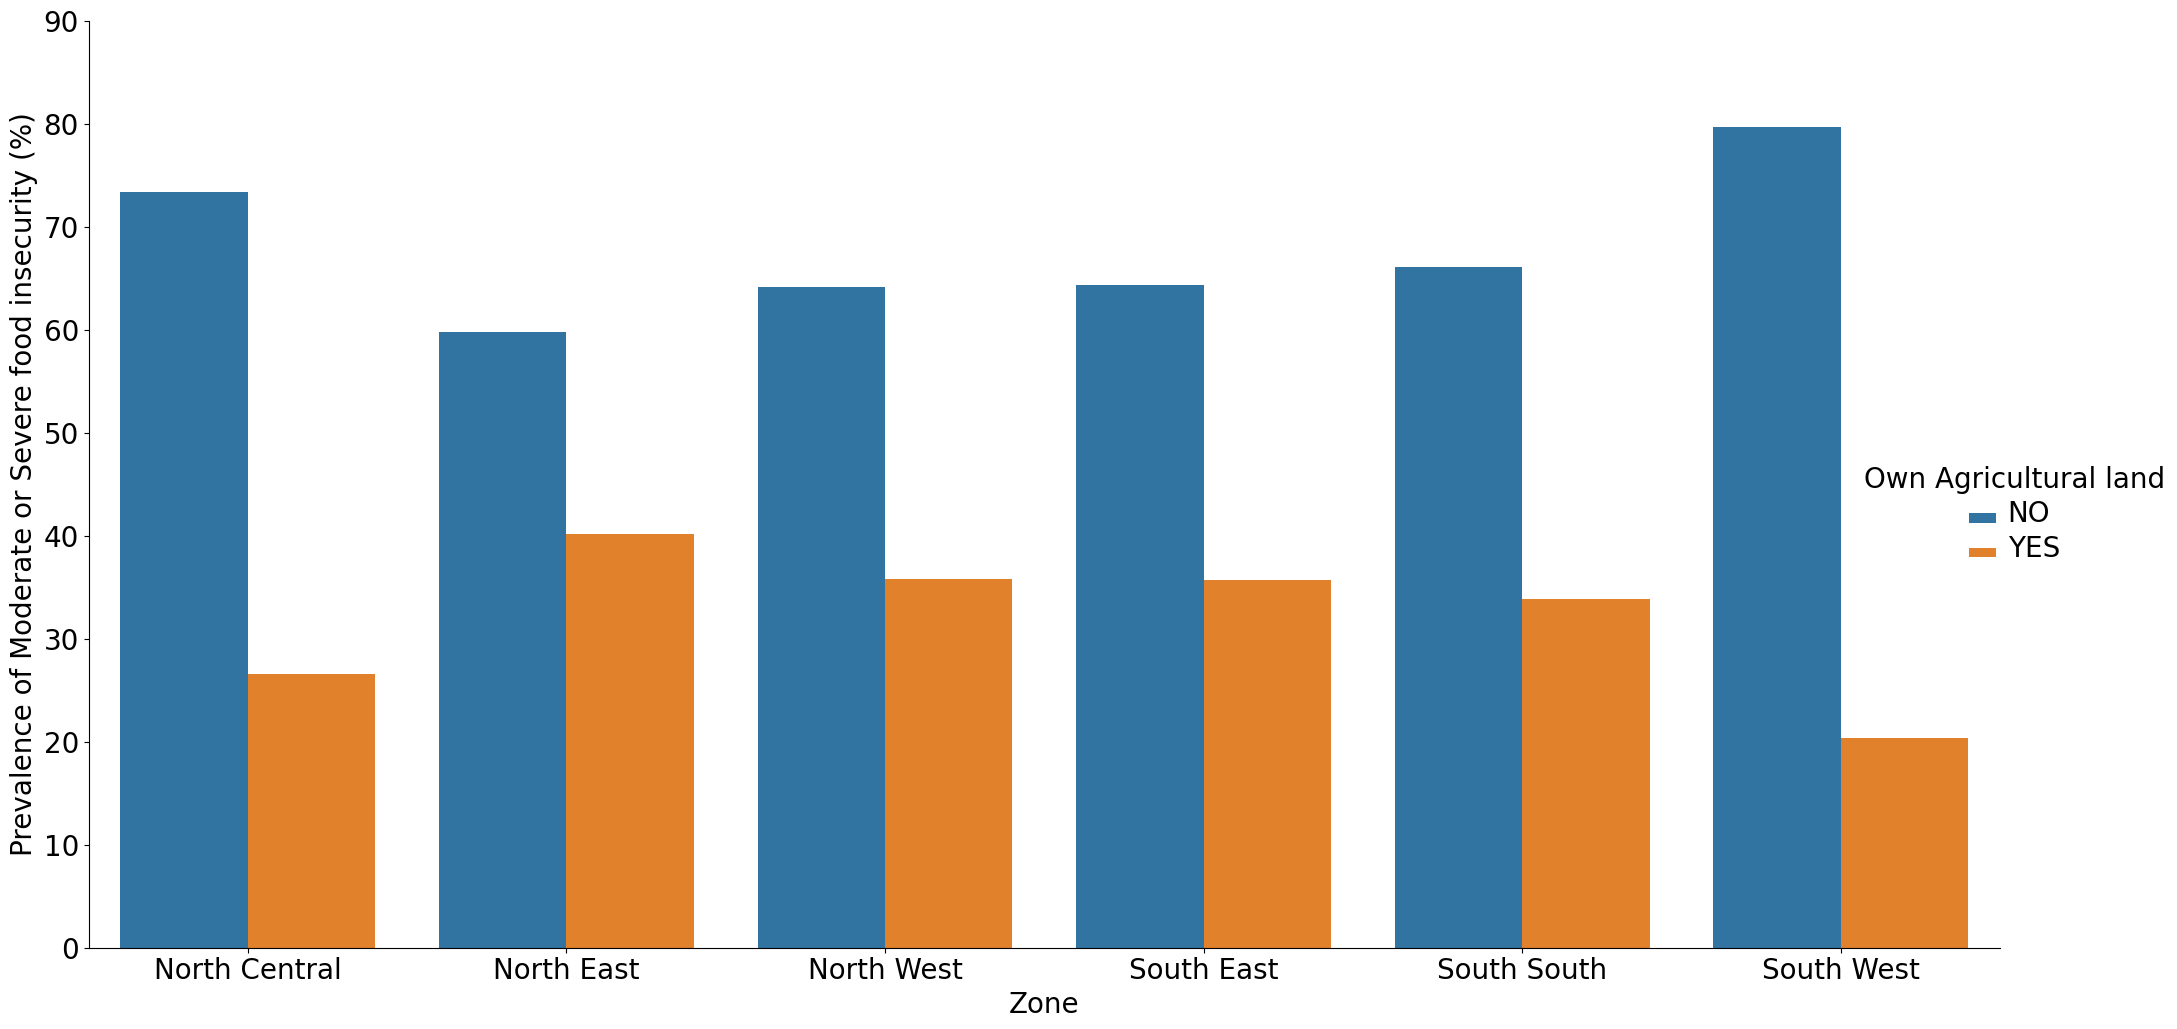

In [88]:
# Moderate or severe (MSI)
prevalence_sfi_zone_agland = proportion_of_fi_by_grp_col(df2, fi_indicator="MSI", 
                                                         zone_col="zone", 
                                                         grp_col="hh_agricultural_land")



g = sns.catplot(x="zone", y="weighted_percentage",
            hue="hh_agricultural_land",
            data=prevalence_sfi_zone_agland, kind="bar",
            height=10,
            # errorbar="se",
            estimator="mean", 
            aspect=2);

# Add y-label
g.set_axis_labels("Zone", "Prevalence of Moderate or Severe food insecurity (%)", fontsize=20)
# Set axis labels with increased font size

# Increase the font size of the tick labels
g.set_xticklabels(fontsize=20)
g.set_yticklabels(fontsize=20)

# Adjust the legend font size
g.legend.set_title("Own Agricultural land", prop={'size': 20})
for text in g.legend.texts:
    text.set_fontsize(20)

[TODO]
* Perform more bivariate analysis

6. Prevalence of food insecurity among urban household, by zone and hh_ag_land_size_cat if hh_agricultural_land is Yes
7. Prevalence of food insecurity among urban household, by zone and hh_own_animal
8. Prevalence of moderate or severe food insecurity by zone by hh_own_dwelling
9. 
* Add insights and interpretation to the results.


## Next: Summary Statistics


In [97]:
# Save the DataFrame that will be used
df2.to_csv("../processed_data/df_for_descriptive_stats.csv", index=False)
print(df2.shape)

(10680, 64)



<hr>
<div>
    <a href="./2_hh_mics6_rasch_model.ipynb">
        <button>&#8592; Rasch Model Analysis</button>
    </a>
    <a href="./4_hh_mics6_descriptive_statictics.ipynb">
        <button style="float: right;">Descriptive Statistic Analysis &#8594;</button>
    </a>
</div>
<hr>